# MRS second order response
In this notebook we derive a correction for the spectral leak present in MRS band 3A detector images (see MIRI-TN-00002-KUL written by Dr. Bart Vandenbussche).

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

MIRI-TN-00002-KUL section 2: The MRS spectrometers are designed to cover the respective spectral band wavelength ranges in the first spectral order. A diffraction grating will yield maximum constructive interference for light of wavelength λ in the first order at an exit angle α. At the same exit angle α maximum constructive interference will also be seen for light of wavelength λ/2 (second order), λ/3 (third order), etc... Without a proper pre-selection of the wavelength bandpass entering the spectrometer, (parts of) these higher order spectra will be superimposed on the first order spectrum.  
  
Such an occurence is expected to happen in MRS band 3A due to a spectral leakage from the dichroic transmission in band 1B. This is shown below.

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.convolution import convolve
import scipy.interpolate as scp_interpolate
from astropy.io import fits
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

# import warnings
# warnings.simplefilter('ignore')

In [2]:
# MRS spectral bands and detector pixel dimensions
bands = ["1B","3A"]

In [3]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'
MRSWaveCalDir = workDir+"MRSWaveCal/" 
MTSDir        = workDir+'MRSFluxCal/MIRI_CDP6MRSFluxCal/MtsIrradiance/'
MrsFilterTransmDir   = MRSWaveCalDir+"MrsFilterTransmissions/"

In [4]:
point_source_sci_1B,point_source_bkg_1B = mrsobs.FM_MTS_800K_BB_MRS_RAD_06_raster(lvl2path,'1B')
point_source_sci_3A,point_source_bkg_3A = mrsobs.FM_MTS_800K_BB_MRS_RAD_06_raster(lvl2path,'3A')

In [5]:
point_source_bkgsubtr_1B = point_source_sci_1B-point_source_bkg_1B
point_source_bkgsubtr_3A = point_source_sci_3A-point_source_bkg_3A

In [6]:
d2cMaps_1B = funcs.load_obj('d2cMaps_band1B',path=d2cMapDir)
d2cMaps_3A = funcs.load_obj('d2cMaps_band3A',path=d2cMapDir)

In [7]:
specres_table_1B = funcs.get_cdps('1B',cdpDir)[4]
specres_table_3A = funcs.get_cdps('3A',cdpDir)[4]
lambcens_1B,lambfwhms_1B = funcs.spectral_gridding('1B',d2cMaps_1B,specres_table=specres_table_1B)
lambcens_3A,lambfwhms_3A = funcs.spectral_gridding('3A',d2cMaps_3A,specres_table=specres_table_3A)

In [53]:
# plt.figure()
# plt.plot(point_source_bkgsubtr_1B[512,:512])
# plt.plot(point_source_bkgsubtr_3A[512,512:])
# plt.tight_layout()

target_position = [d2cMaps_3A['alphaMap'][487,575],d2cMaps_3A['lambdaMap'][487,575],d2cMaps_3A['betaMap'][487,575]]

i,j = np.where((d2cMaps_1B['sliceMap']>100) & (d2cMaps_1B['sliceMap']<200)) 
beta_idx = np.abs((np.unique(d2cMaps_1B['betaMap'][i,j])-target_position[2])).argmin()
beta_list = np.unique(d2cMaps_1B['betaMap'][i,j])
beta1, beta2, beta3 = beta_list[beta_idx-1],beta_list[beta_idx],beta_list[beta_idx+1]

print target_position[2]
print beta1,beta2,beta3

# print d2cMaps_3A['alphaMap'][487,575], d2cMaps_3A['betaMap'][487,575],d2cMaps_3A['lambdaMap'][487,575], point_source_bkgsubtr_1B[487,575]
# print d2cMaps_3A['alphaMap'][487,576], d2cMaps_3A['betaMap'][487,576],d2cMaps_3A['lambdaMap'][487,576], point_source_bkgsubtr_1B[487,576]
# print d2cMaps_3A['alphaMap'][487,574], d2cMaps_3A['betaMap'][487,574],d2cMaps_3A['lambdaMap'][487,574], point_source_bkgsubtr_1B[487,574]

-0.194906889164
-0.354408353382 -0.177204176691 0.0


In [17]:
sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_signal = [{} for i in range(6)]

sign_amp['1B'],alpha_centers['1B'],beta_centers['1B'],sigma_alpha['1B'],sigma_beta['1B'],bkg_signal['1B'] = funcs.point_source_centroiding('1B',point_source_bkgsubtr_1B,d2cMaps_1B,spec_grid=[lambcens_1B,lambfwhms_1B],fit='2D')
sign_amp['3A'],alpha_centers['3A'],beta_centers['3A'],sigma_alpha['3A'],sigma_beta['3A'],bkg_signal['3A'] = funcs.point_source_centroiding('3A',point_source_bkgsubtr_3A,d2cMaps_3A,spec_grid=[lambcens_3A,lambfwhms_3A],fit='2D')

STEP 1: Rough centroiding
Slice 11 has the largest summed flux
Source position: beta = 0.0arcsec, alpha = -0.23arcsec 

STEP 2: 1D Gaussian fit


/Users/ioannisa/Desktop/python/miri_devel/funcs.py:502: RuntimeWarning: invalid value encountered in absolute
  if np.abs(np.diff(alpha_centers)[i]) > 0.05:


[Along-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582]

STEP 3: 2D Gaussian fit


/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/scipy/optimize/_lsq/common.py:370: RuntimeWarning: invalid value encountered in greater_equal
  return np.all((x >= lb) & (x <= ub))
/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/scipy/optimize/_lsq/common.py:370: RuntimeWarning: invalid value encountered in less_equal
  return np.all((x >= lb) & (x <= ub))


The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 38, 39, 40, 41, 117, 118, 119, 191, 197, 287, 288, 296, 297, 298, 336, 337, 338, 361, 362, 363, 364, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582]
STEP 1: Rough centroiding
Slice 9 has the largest summed flux
Source position: beta = 0.19arcsec, alpha = 0.97arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 500, 501]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501]

STEP 3: 2D Gaussian fit
The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 160, 161, 162, 163, 167, 168, 169, 170, 2

<IPython.core.display.Javascript object>


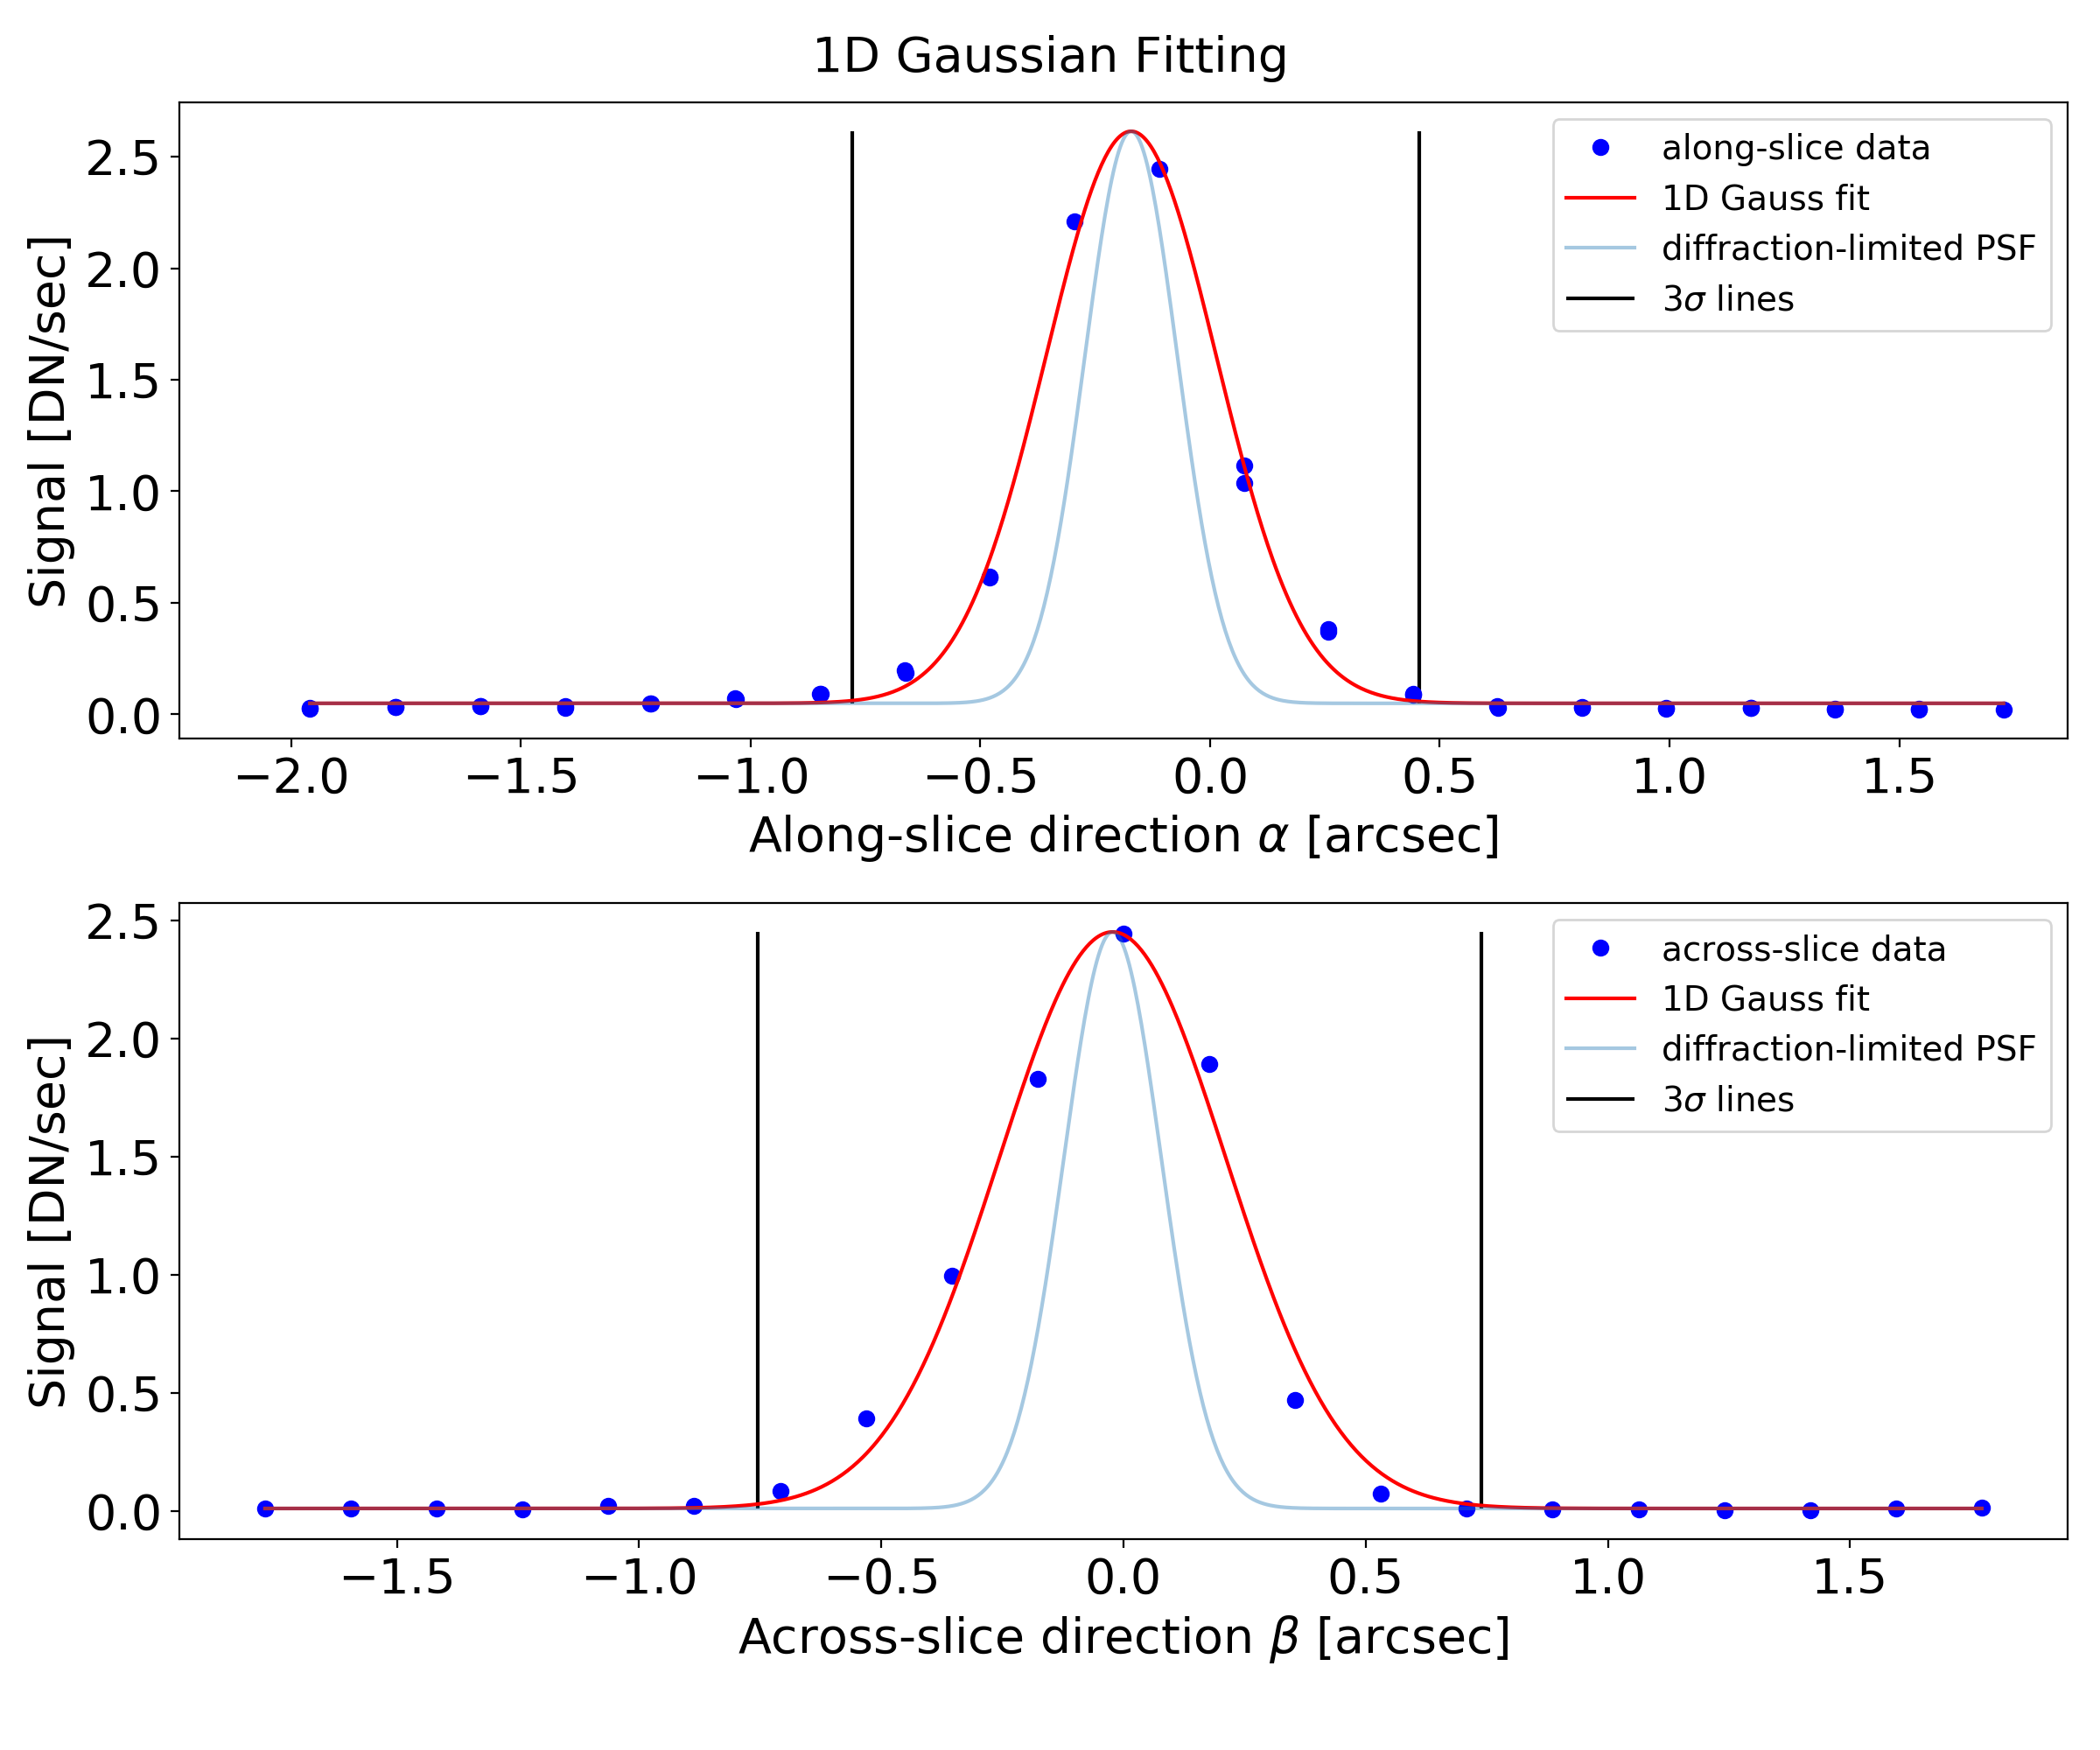

<IPython.core.display.Javascript object>


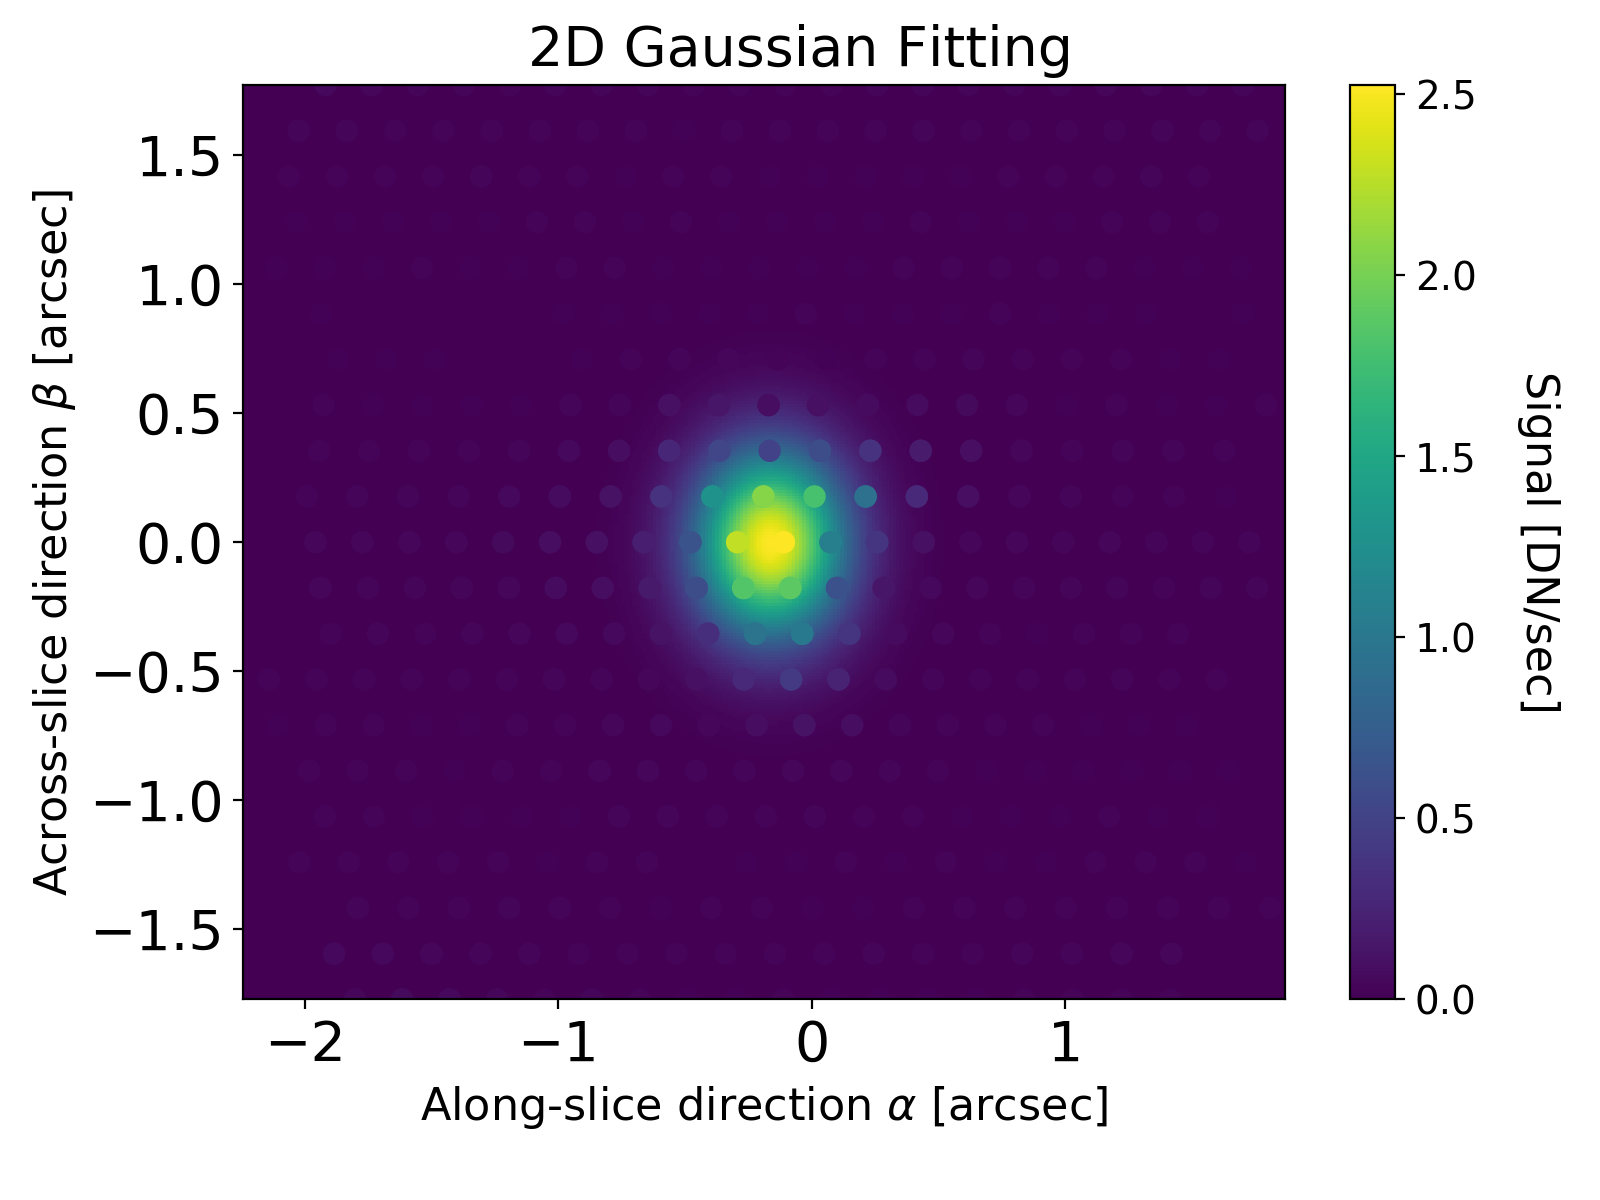

<IPython.core.display.Javascript object>


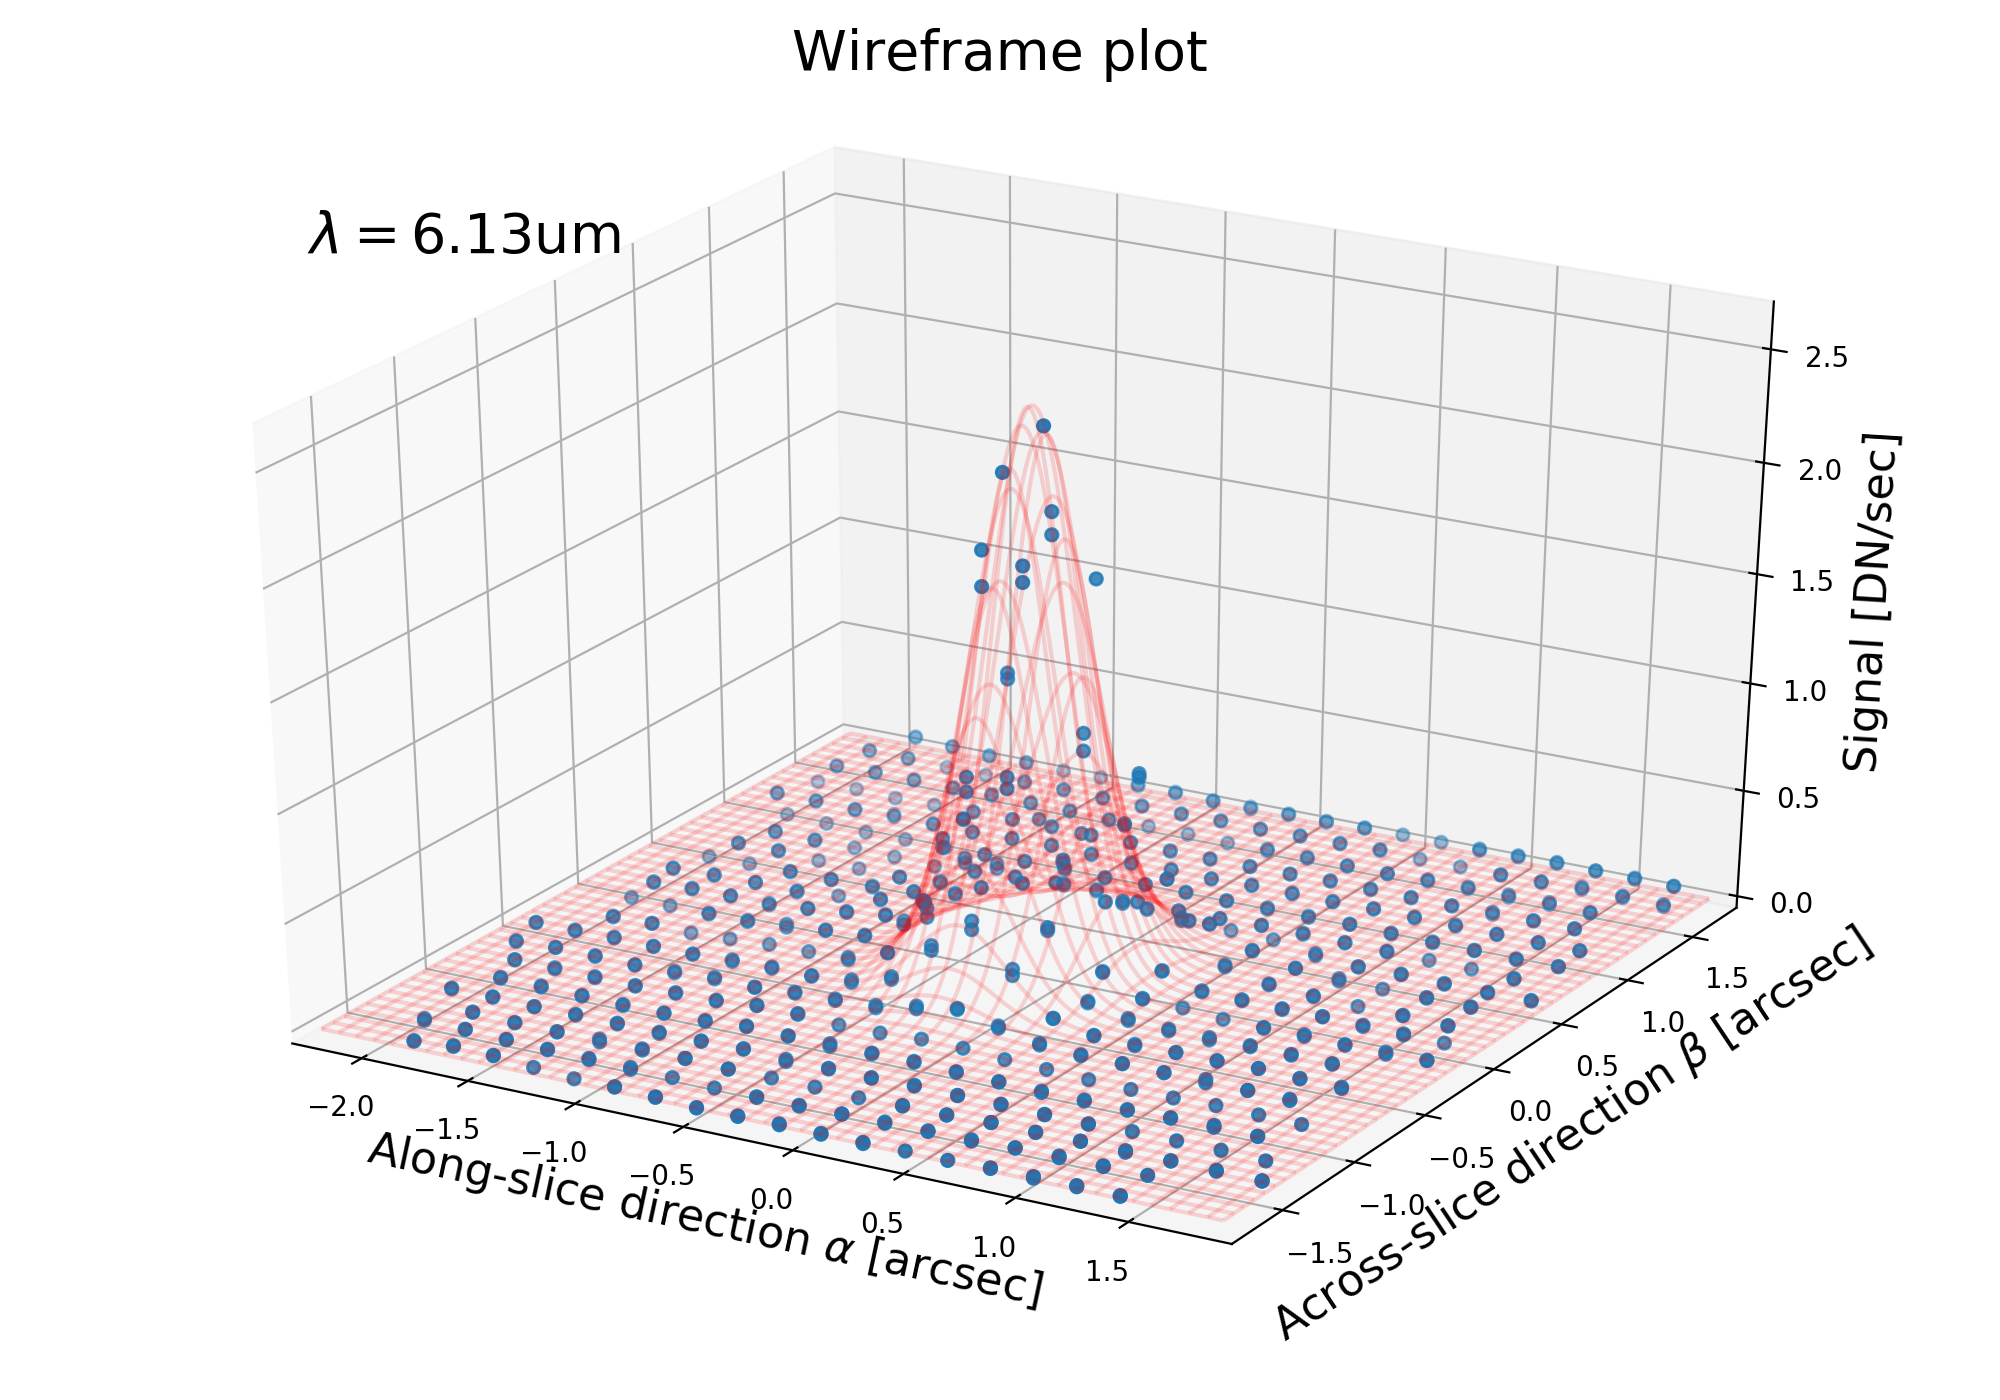

<IPython.core.display.Javascript object>


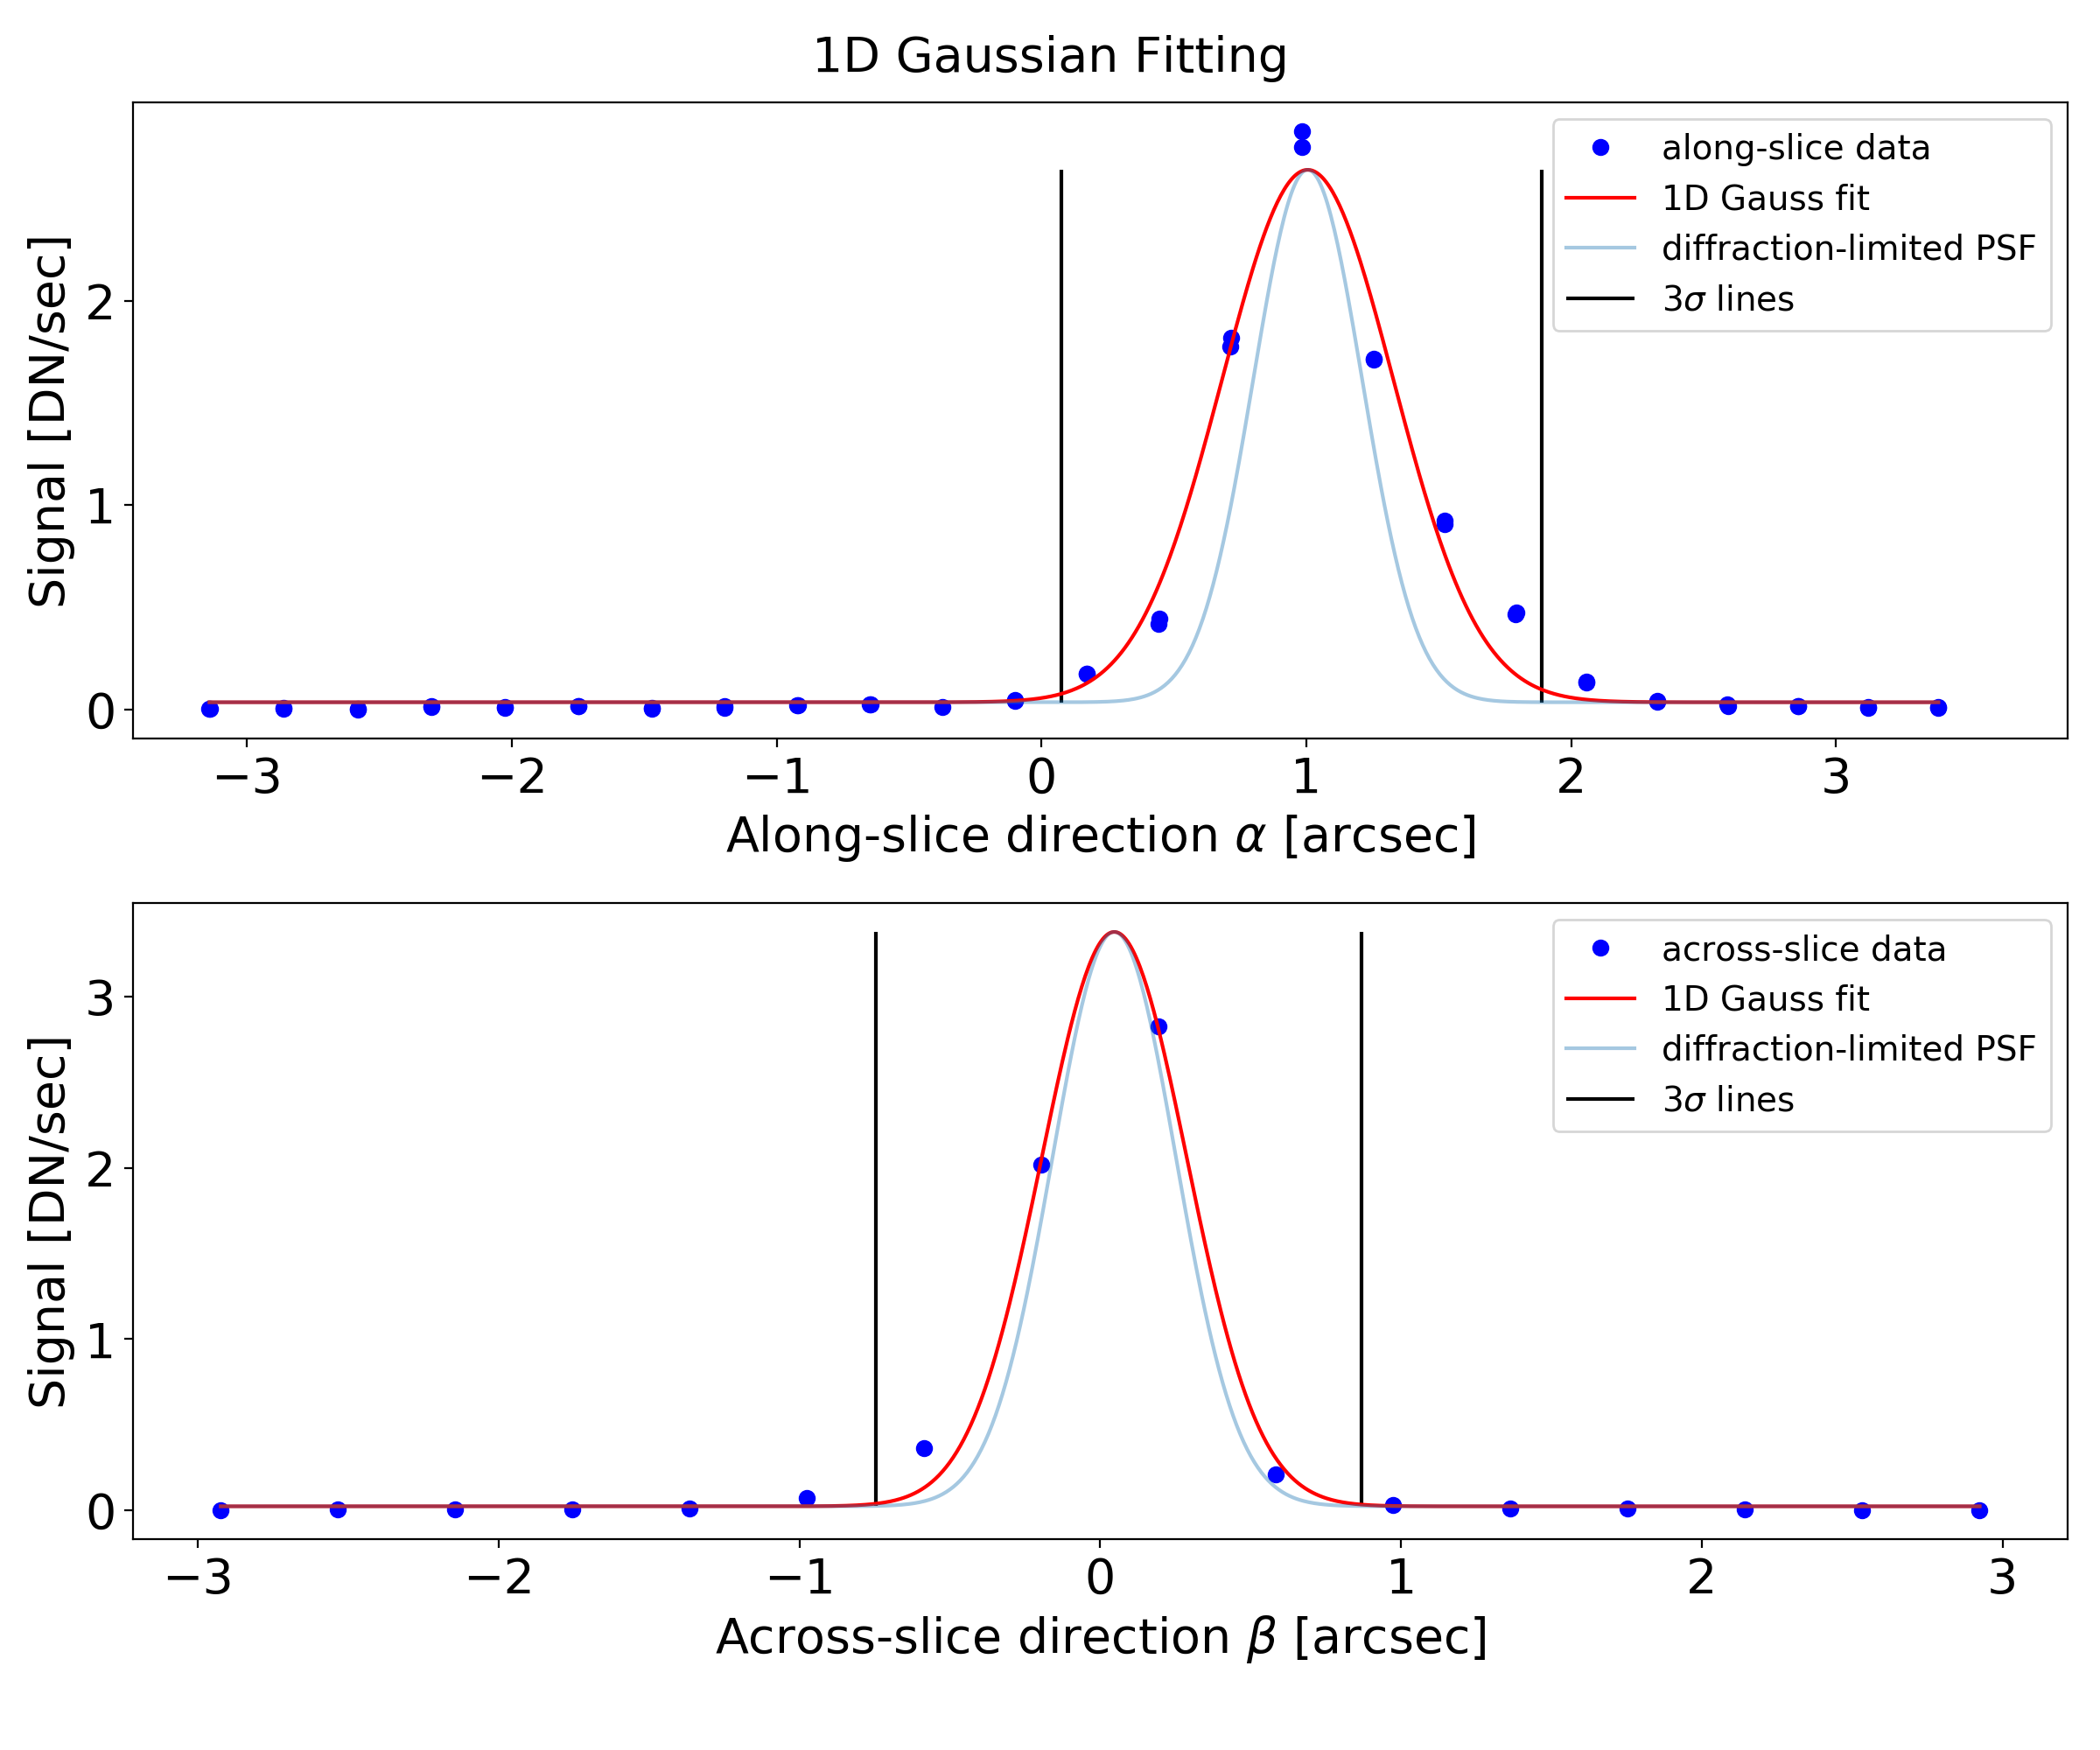

<IPython.core.display.Javascript object>


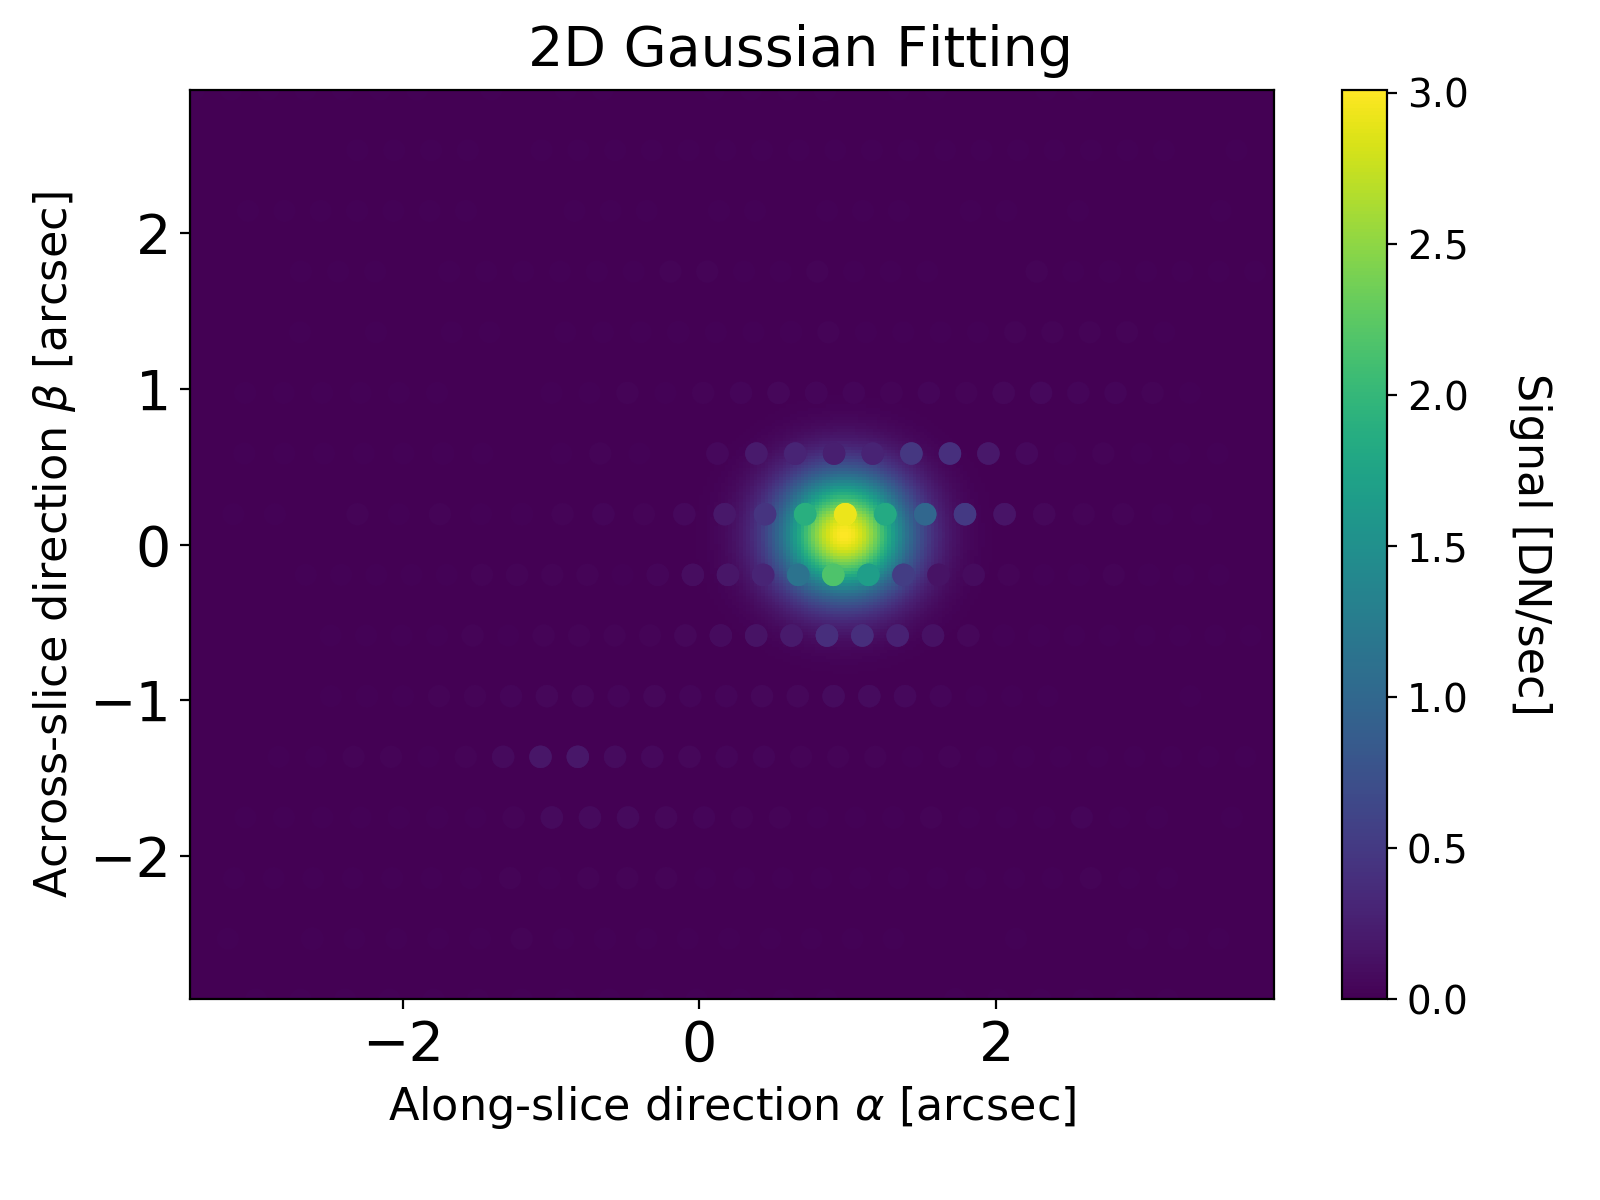

<IPython.core.display.Javascript object>


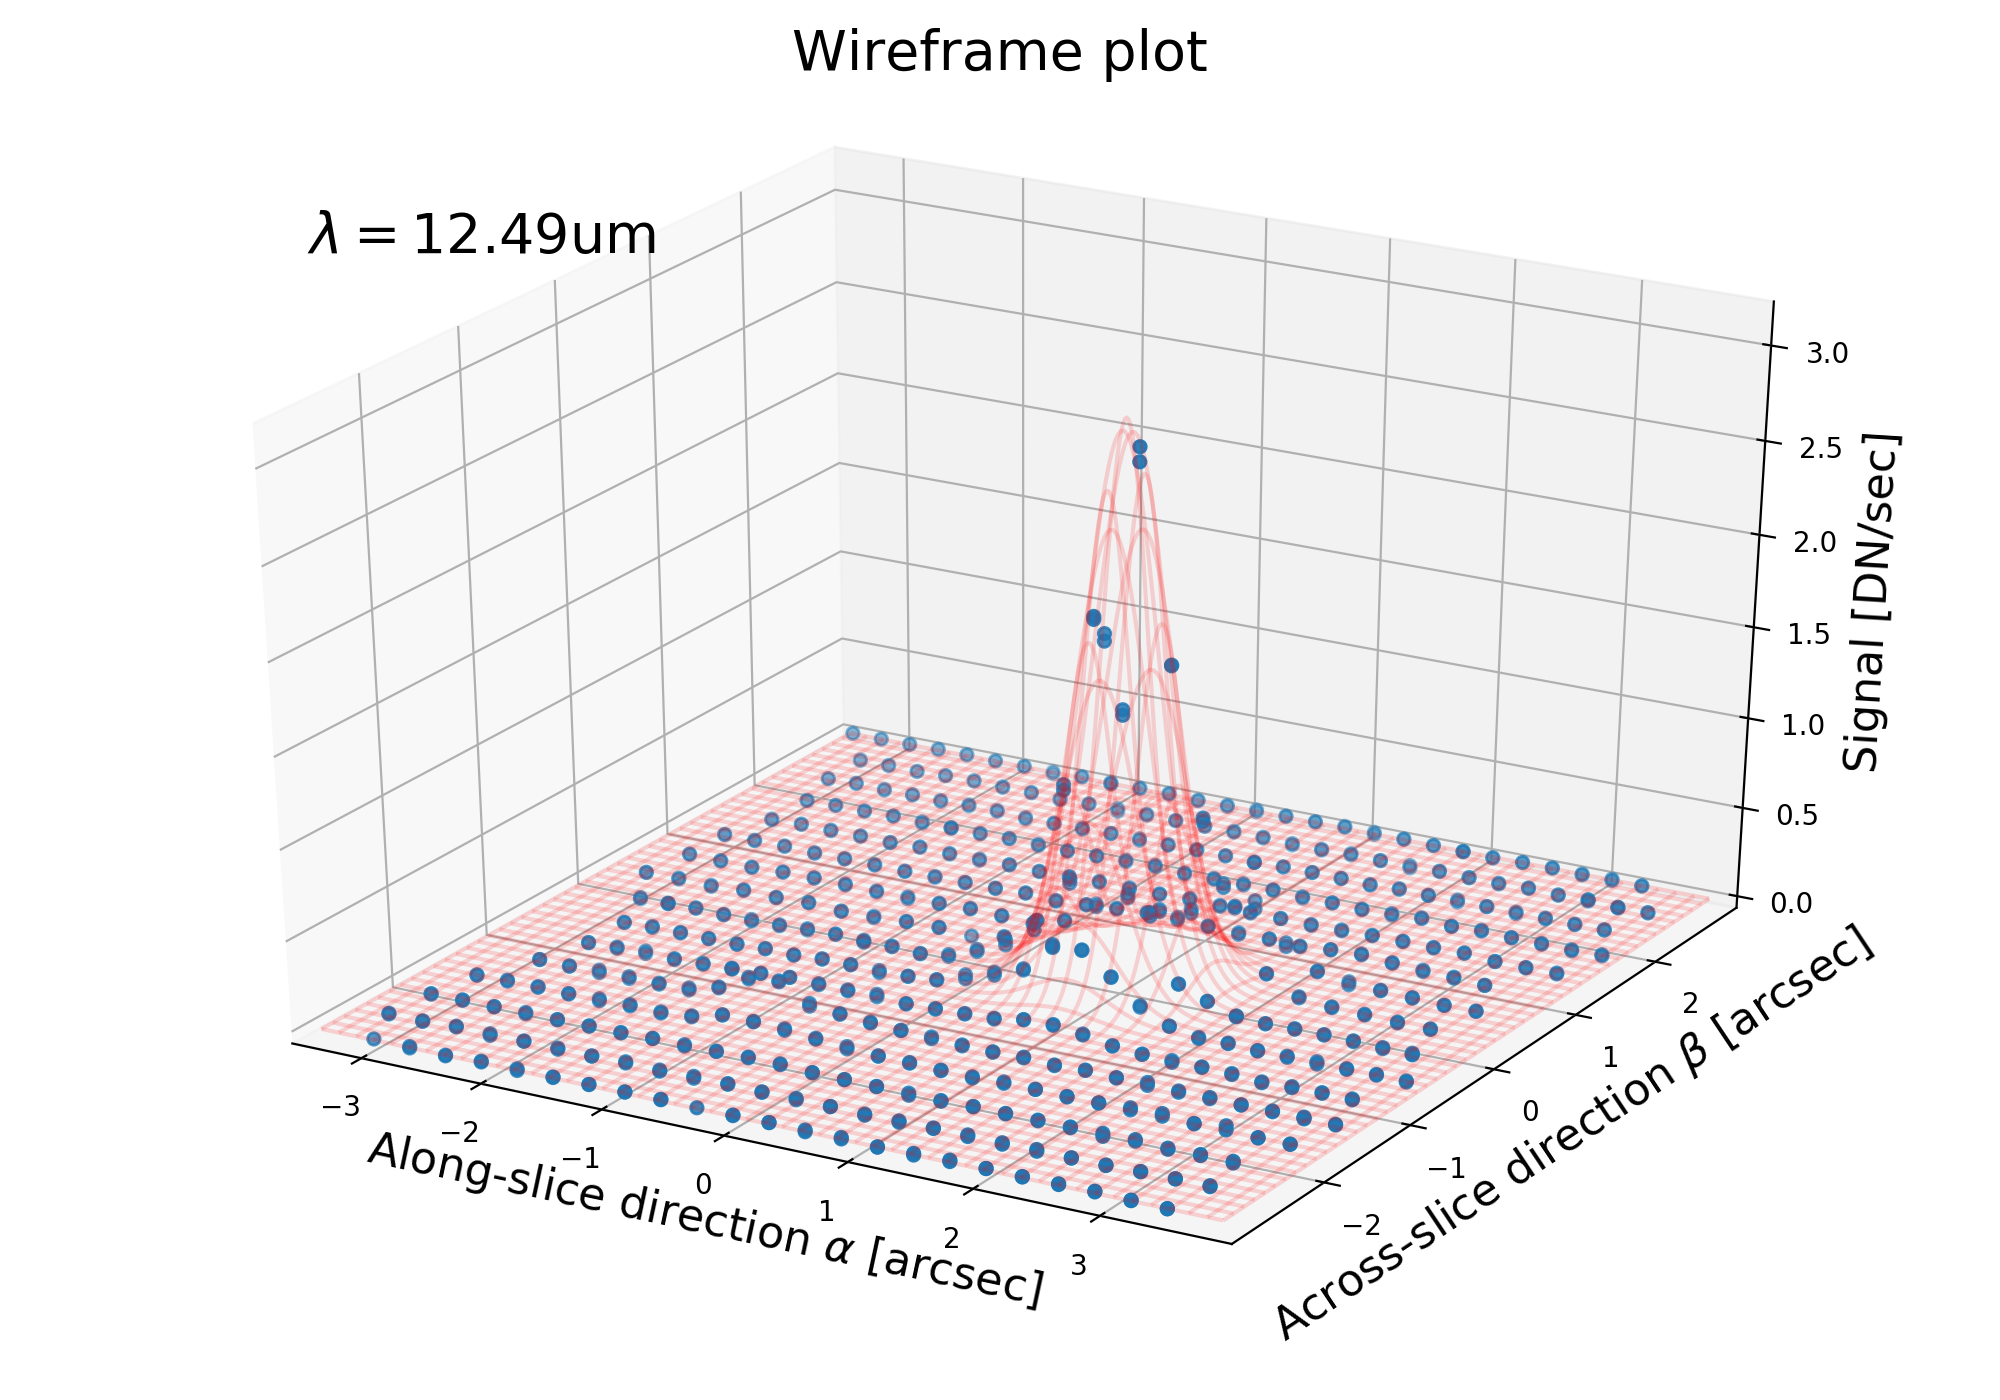

In [18]:
funcs.plot_point_source_centroiding('1B',point_source_bkgsubtr_1B,d2cMaps_1B,spec_grid=[lambcens_1B,lambfwhms_1B],centroid=[sign_amp['1B'],alpha_centers['1B'],beta_centers['1B'],sigma_alpha['1B'],sigma_beta['1B'],bkg_signal['1B']],ibin=len(lambcens_1B)/2,data='slope')
funcs.plot_point_source_centroiding('3A',point_source_bkgsubtr_3A,d2cMaps_3A,spec_grid=[lambcens_3A,lambfwhms_3A],centroid=[sign_amp['3A'],alpha_centers['3A'],beta_centers['3A'],sigma_alpha['3A'],sigma_beta['3A'],bkg_signal['3A']],ibin=len(lambcens_3A)/2,data='slope')

<IPython.core.display.Javascript object>


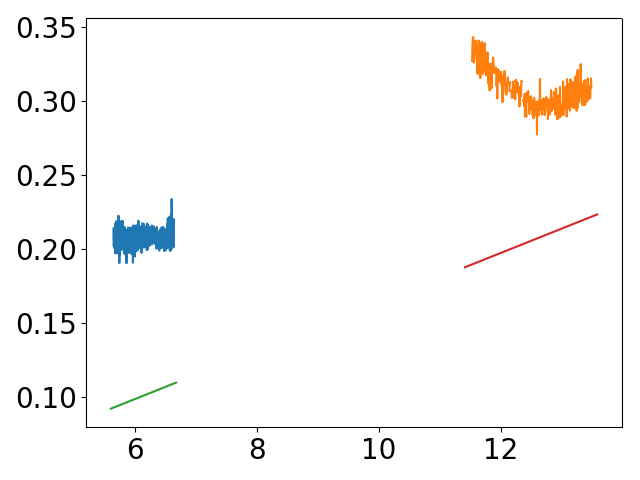

In [150]:
plt.figure()
plt.plot(lambcens_1B,sigma_alpha['1B'])
plt.plot(lambcens_3A,sigma_alpha['3A'])
plt.plot(lambcens_1B,((0.31*lambcens_1B/8.)/2.355))
plt.plot(lambcens_3A,((0.31*lambcens_3A/8.)/2.355))
plt.tight_layout()

<IPython.core.display.Javascript object>


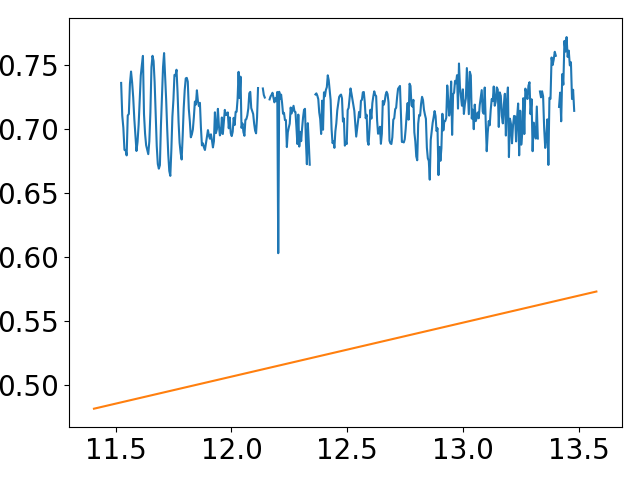

0.389813778328


In [89]:
plt.figure()
plt.plot(lambcens_3A,sigma_beta['3A']/d2cMaps_3A['bdel'])
plt.plot(lambcens_3A,((0.31*lambcens_3A/8.)/2.355)/d2cMaps_3A['bdel'])
plt.tight_layout()

print d2cMaps_3A['bdel']

<IPython.core.display.Javascript object>


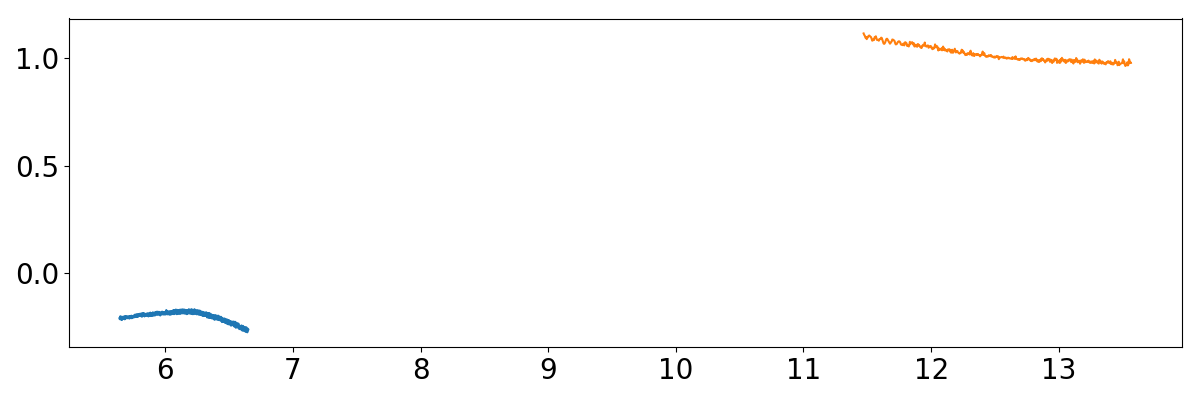

In [10]:
plt.figure(figsize=(12,4))
plt.plot(lambcens_1B,alpha_centers['1B'])
plt.plot(lambcens_3A,alpha_centers['3A'])
plt.tight_layout()

<IPython.core.display.Javascript object>


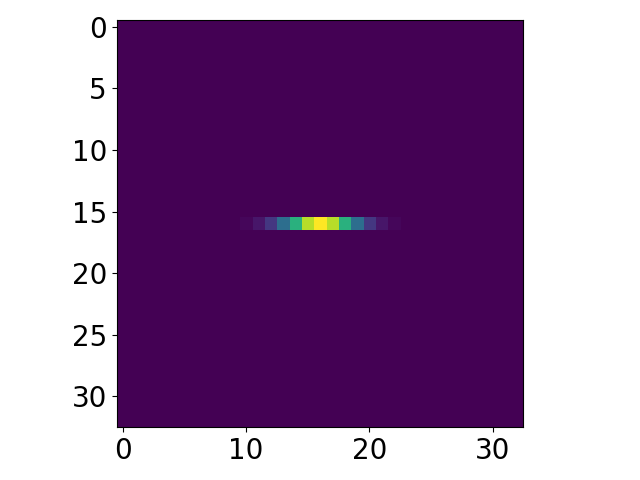

In [178]:
nx,ny = 2**4,2**4
x = np.arange(-nx, nx+1)
y = np.arange(-ny, ny+1)
xi, yi = np.meshgrid(x, y)
yxi = np.vstack([xi.ravel(), yi.ravel()])

kernel = funcs.gauss2d(yxi, 1, 0, 0, 2.1, 0.01, 0)
kernel/= kernel.sum()
kernel.shape = xi.shape

plt.figure()
plt.imshow(kernel)
plt.tight_layout()

In [179]:
degrade4 = convolve(point_source_bkgsubtr_1B, kernel)

<IPython.core.display.Javascript object>


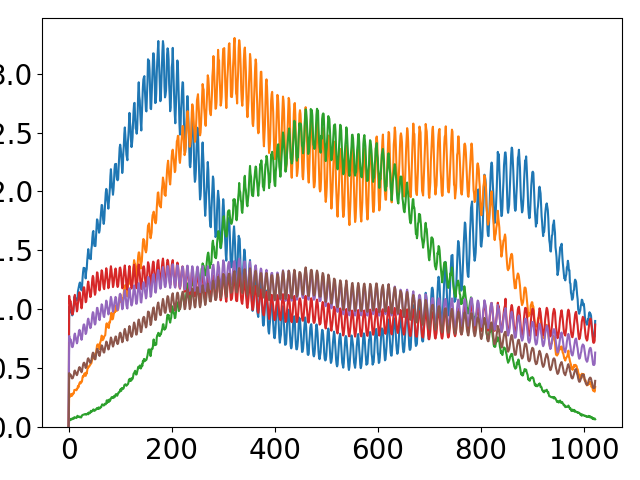

In [184]:
plt.figure()
plt.plot(point_source_bkgsubtr_1B[:,26])
plt.plot(point_source_bkgsubtr_1B[:,27])
plt.plot(point_source_bkgsubtr_1B[:,28])
# plt.plot(degrade[:,26])
# plt.plot(degrade2[:,26])
# plt.plot(degrade3[:,26])
plt.plot(degrade4[:,26])
plt.plot(degrade4[:,27])
plt.plot(degrade4[:,28])
plt.ylim(0)
plt.tight_layout()

<IPython.core.display.Javascript object>


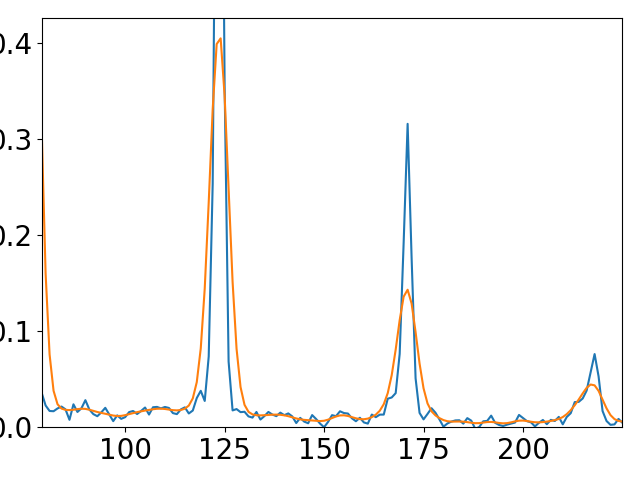

In [181]:
plt.figure()
plt.plot(point_source_bkgsubtr_1B[512,:])
# plt.plot(degrade[512,:])
# plt.plot(degrade2[512,:])
plt.plot(degrade4[512,:])
plt.ylim(0)
plt.tight_layout()

[ 1.08047274  0.97186768  1.0124924   1.1008048   1.79638979  1.29735359]


<IPython.core.display.Javascript object>


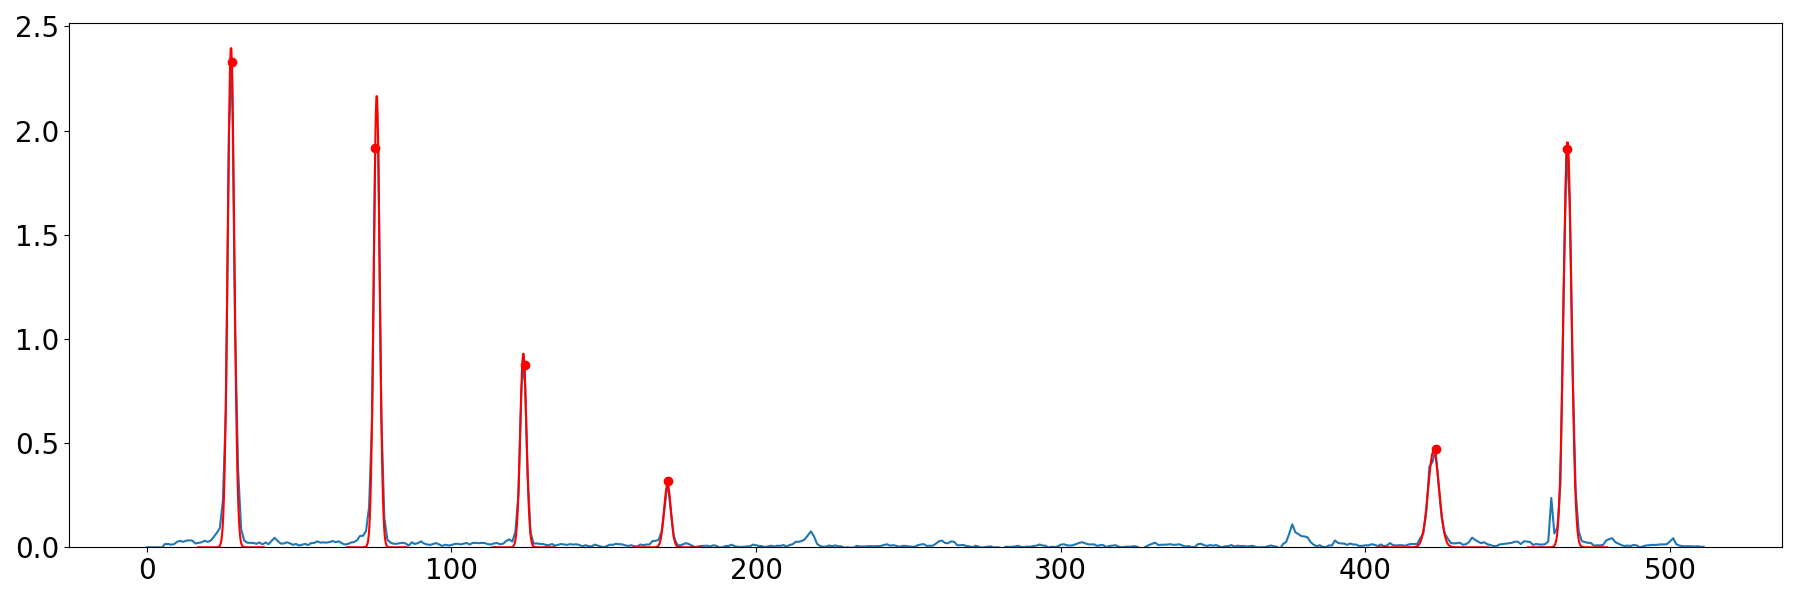

In [107]:
from scipy.optimize import curve_fit
ydata = point_source_bkgsubtr_1B[512,:512]
ydata[np.isnan(ydata)] = 0.
ydata[ydata<0] = 0.
xdata = np.arange(len(ydata))
peaks = funcs.find_peaks(ydata,thres=0.1,min_dist=20)

bounds_gauss = ([0,0,0],[np.inf,np.inf,np.inf])

fitparams = []
fiterrors = []
fitting_flag = []
range_ini = np.full(len(peaks),np.nan) # fit range first position
range_fin = np.full(len(peaks),np.nan) # fit range last position
for i in range(len(peaks)):
    N = 10

    peak_idx = peaks[i]
    
    guess_gauss = [ydata[peak_idx],xdata[peak_idx],1.]
    
    range_ini[i] = xdata[peak_idx-N]
    range_fin[i] = xdata[peak_idx+N]
    popt,pcov = curve_fit(funcs.gauss1d_woBaseline,xdata[peak_idx-N:peak_idx+N],ydata[peak_idx-N:peak_idx+N],p0=guess_gauss,absolute_sigma=True,bounds=bounds_gauss)
    fitting_flag.append('gauss1d')
    
    fitparams.append(popt)
    fiterrors.append(pcov)
    
amplitudes  = funcs.get_amplitude(fitparams,fitting_flag)
linecenters = funcs.get_linecenter(fitparams,fitting_flag)
sigmas      = funcs.get_FWHM(fitparams,fitting_flag)/2.355

print sigmas

plt.figure(figsize=(18,6))
plt.plot(point_source_bkgsubtr_1B[512,:512])
plt.plot(peaks,point_source_bkgsubtr_1B[512,peaks],'ro')
funcs.plot_etalon_fit(fitparams,fitting_flag)
plt.ylim(0)
plt.tight_layout()

In [141]:
all_amps,all_linecens,all_sigmas = [],[],[]
for ypos in [100,200,300,400,500,600,700,900]:
    print ypos
    ydata = point_source_bkgsubtr_3A[ypos,:]
    ydata[np.isnan(ydata)] = 0.
    ydata[ydata<0] = 0.
    xdata = np.arange(len(ydata))
    peaks = funcs.find_peaks(ydata,thres=0.1,min_dist=20)

    bounds_gauss = ([0,0,0],[np.inf,np.inf,np.inf])

    fitparams = []
    fiterrors = []
    fitting_flag = []
    range_ini = np.full(len(peaks),np.nan) # fit range first position
    range_fin = np.full(len(peaks),np.nan) # fit range last position
    for i in range(len(peaks)):
        N = 10

        peak_idx = peaks[i]

        guess_gauss = [ydata[peak_idx],xdata[peak_idx],1.]

        range_ini[i] = xdata[peak_idx-N]
        range_fin[i] = xdata[peak_idx+N]
        popt,pcov = curve_fit(funcs.gauss1d_woBaseline,xdata[peak_idx-N:peak_idx+N],ydata[peak_idx-N:peak_idx+N],p0=guess_gauss,absolute_sigma=True,bounds=bounds_gauss)
        fitting_flag.append('gauss1d')

        fitparams.append(popt)
        fiterrors.append(pcov)

    amplitudes  = funcs.get_amplitude(fitparams,fitting_flag)
    linecenters = funcs.get_linecenter(fitparams,fitting_flag)
    sigmas      = funcs.get_FWHM(fitparams,fitting_flag)/2.355
    
    all_amps.append(amplitudes)
    all_linecens.append(linecenters)
    all_sigmas.append(sigmas)

# plt.figure(figsize=(18,6))
# plt.plot(point_source_bkgsubtr_1B[512,:512])
# plt.plot(peaks,point_source_bkgsubtr_1B[512,peaks],'ro')
# funcs.plot_etalon_fit(fitparams,fitting_flag)
# plt.ylim(0)
# plt.tight_layout()

100
200
300
400
500
600
700
900


In [149]:
# plt.figure(figsize=(12,6))
for i in range(len([100,200,300,400,500,600,700,900])):
    print all_sigmas[i]
#     if len(all_sigmas[i])==6:
#         plt.plot(i,all_sigmas[i][0],'bo')
#         plt.plot(i,all_sigmas[i][1],'ro')
#         plt.plot(i,all_sigmas[i][2],'go')
#         plt.scatter(i,all_sigmas[i][3],c='orange')
#         plt.scatter(i,all_sigmas[i][4],c='magenta')
#         plt.scatter(i,all_sigmas[i][5],c='k')
#     else: continue
# plt.tight_layout()

[ 1.45907266  1.10072023  1.77695648  2.36107685  1.25789287]
[ 1.10751783  1.74769112  2.35344587  1.2405889 ]
[ 1.12816175  1.8239901   2.37149694  1.21031994]
[ 1.11141191  1.67225668  2.36390911  1.19359013]
[ 1.0711226   1.79602205  2.32787562  1.21669062]
[ 1.06750323  1.62890221  2.36742782  1.2394751 ]
[ 1.35948693  1.09551061  1.72229745  2.41757013  1.2901715 ]
[ 1.40486999  1.0903186   1.61090707  2.49193929  1.36775001]


<IPython.core.display.Javascript object>


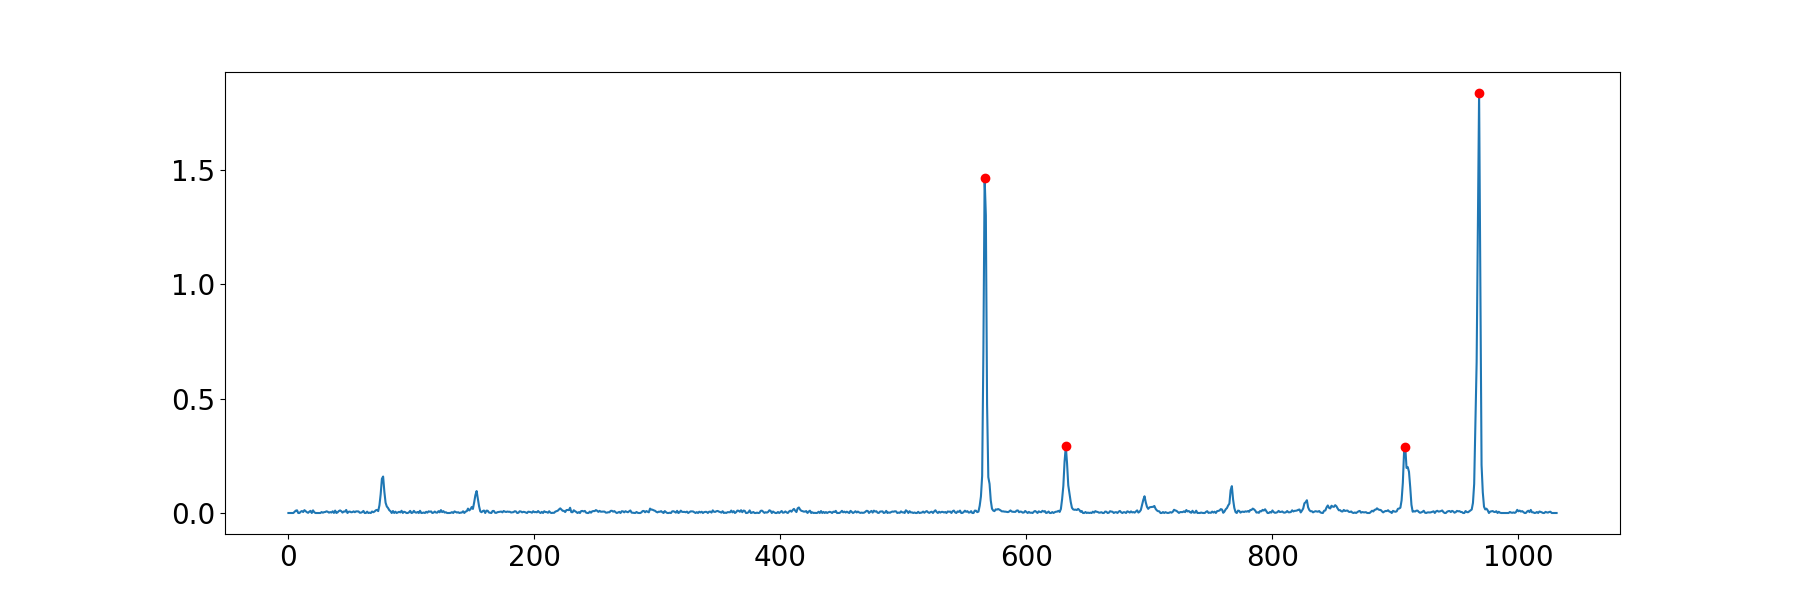

In [140]:
ydata = point_source_bkgsubtr_3A[200,:]
ydata[np.isnan(ydata)] = 0.
ydata[ydata<0] = 0.
xdata = np.arange(len(ydata))
peaks = funcs.find_peaks(ydata,thres=0.1,min_dist=20)

plt.figure(figsize=(18,6))
plt.plot(point_source_bkgsubtr_3A[200,:])
plt.plot(peaks,point_source_bkgsubtr_3A[200,peaks],'ro')

# fitparams = []
# fiterrors = []
# fitting_flag = []
# range_ini = np.full(len(peaks),np.nan) # fit range first position
# range_fin = np.full(len(peaks),np.nan) # fit range last position
# for i in range(len(peaks)):
#     N = 10

#     peak_idx = peaks[i]
    
#     guess_gauss = [ydata[peak_idx],xdata[peak_idx],1.]
    
#     range_ini[i] = xdata[peak_idx-N]
#     range_fin[i] = xdata[peak_idx+N]
#     popt,pcov = curve_fit(funcs.gauss1d_woBaseline,xdata[peak_idx-N:peak_idx+N],ydata[peak_idx-N:peak_idx+N],p0=guess_gauss,absolute_sigma=True,bounds=bounds_gauss)
#     fitting_flag.append('gauss1d')
    
#     fitparams.append(popt)
#     fiterrors.append(pcov)
    
# linecenters = funcs.get_linecenter(fitparams,fitting_flag)
# amplitudes  = funcs.get_amplitude(fitparams,fitting_flag)
# sigmas      = funcs.get_FWHM(fitparams,fitting_flag)/2.355

# print sigmas

# plt.figure(figsize=(18,6))
# plt.plot(point_source_bkgsubtr_3A[512,:])
# plt.plot(peaks,point_source_bkgsubtr_3A[512,peaks],'ro')
# funcs.plot_etalon_fit(fitparams,fitting_flag)
# plt.ylim(0)
# plt.tight_layout()

<IPython.core.display.Javascript object>


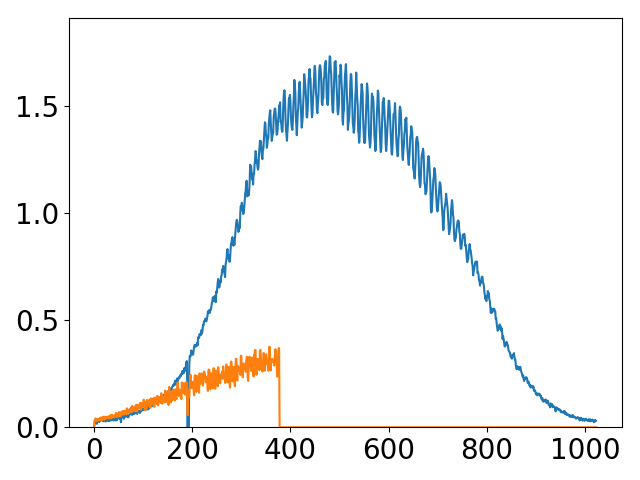

In [33]:
plt.figure()
plt.plot(point_source_bkgsubtr_1B[:,467])
plt.plot(degrade_img[:,467])
plt.ylim(0)
plt.tight_layout()

<IPython.core.display.Javascript object>


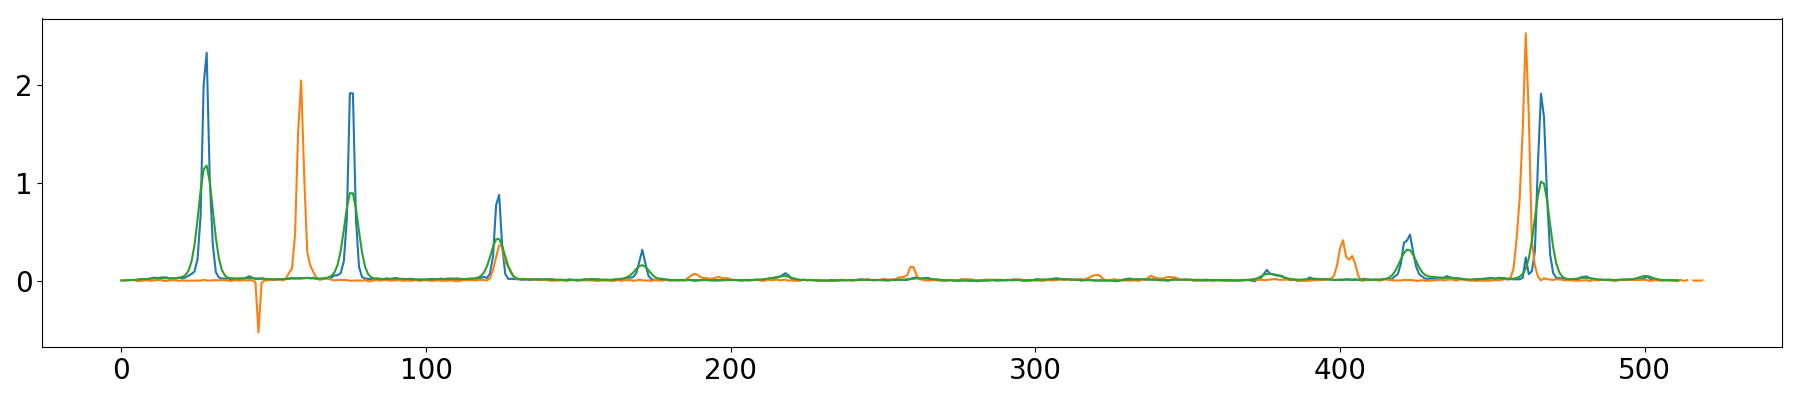

In [66]:
plt.figure(figsize=(18,4))
plt.plot(np.arange(len(point_source_bkgsubtr_1B[512,:512])),point_source_bkgsubtr_1B[512,:512])
plt.plot(np.arange(len(point_source_bkgsubtr_3A[512,512:])),point_source_bkgsubtr_3A[512,512:])
plt.plot(degrade[512,:512])
plt.tight_layout()

In [25]:
psffits_1B = funcs.get_cdps('1B',cdpDir,output='img')[3]
psf_img_1B = funcs.evaluate_psf_cdp(psffits_1B,d2cMaps_1B,source_center=[np.mean(alpha_centers['1B'][~np.isnan(alpha_centers['1B'])]),np.mean(beta_centers['1B'][~np.isnan(beta_centers['1B'])])])

# psffits_3A = funcs.get_cdps('3A',cdpDir,output='img')[3]
# psf_img_3A = funcs.evaluate_psf_cdp(psffits_3A,d2cMaps_3A,source_center=[0,0])


<IPython.core.display.Javascript object>


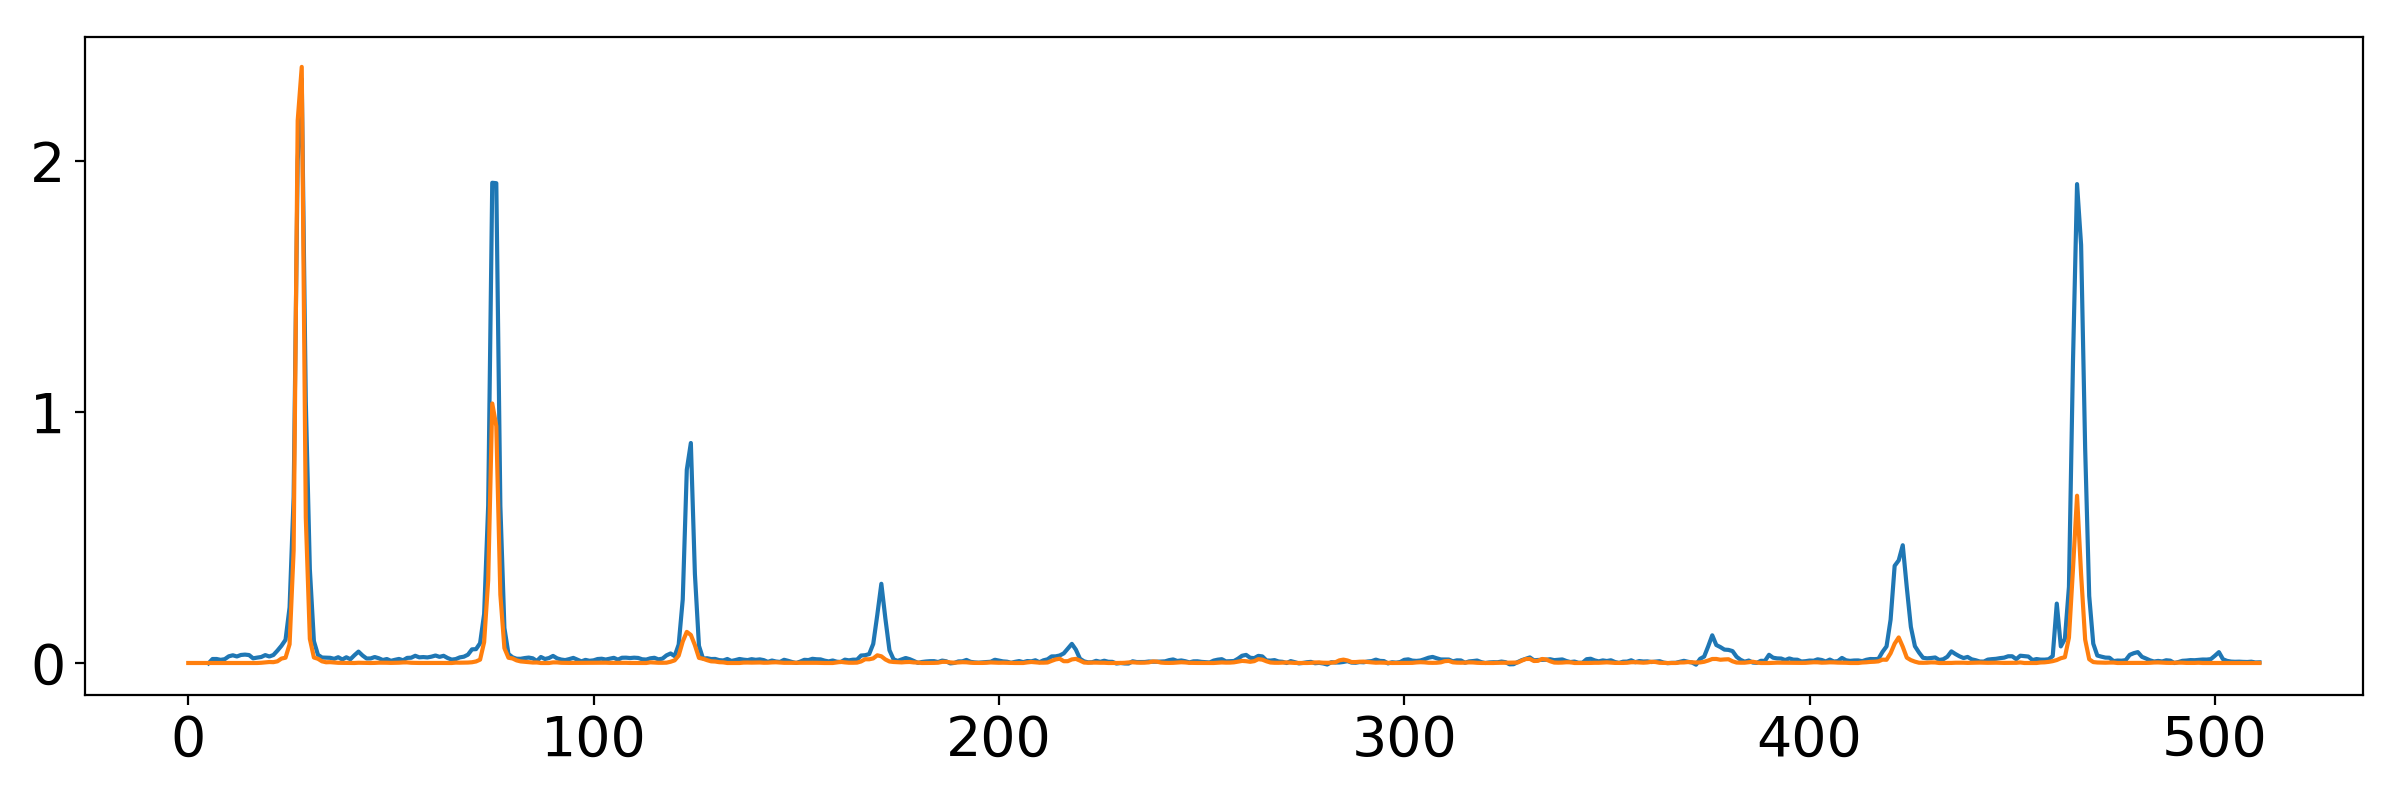

In [29]:
plt.figure(figsize=(12,4))
plt.plot(np.arange(len(point_source_bkgsubtr_1B[512,:512])),point_source_bkgsubtr_1B[512,:512])
plt.plot(np.arange(len(psf_img_1B[512,:512])),psf_img_1B[512,:512]*350.)
plt.tight_layout()

<IPython.core.display.Javascript object>


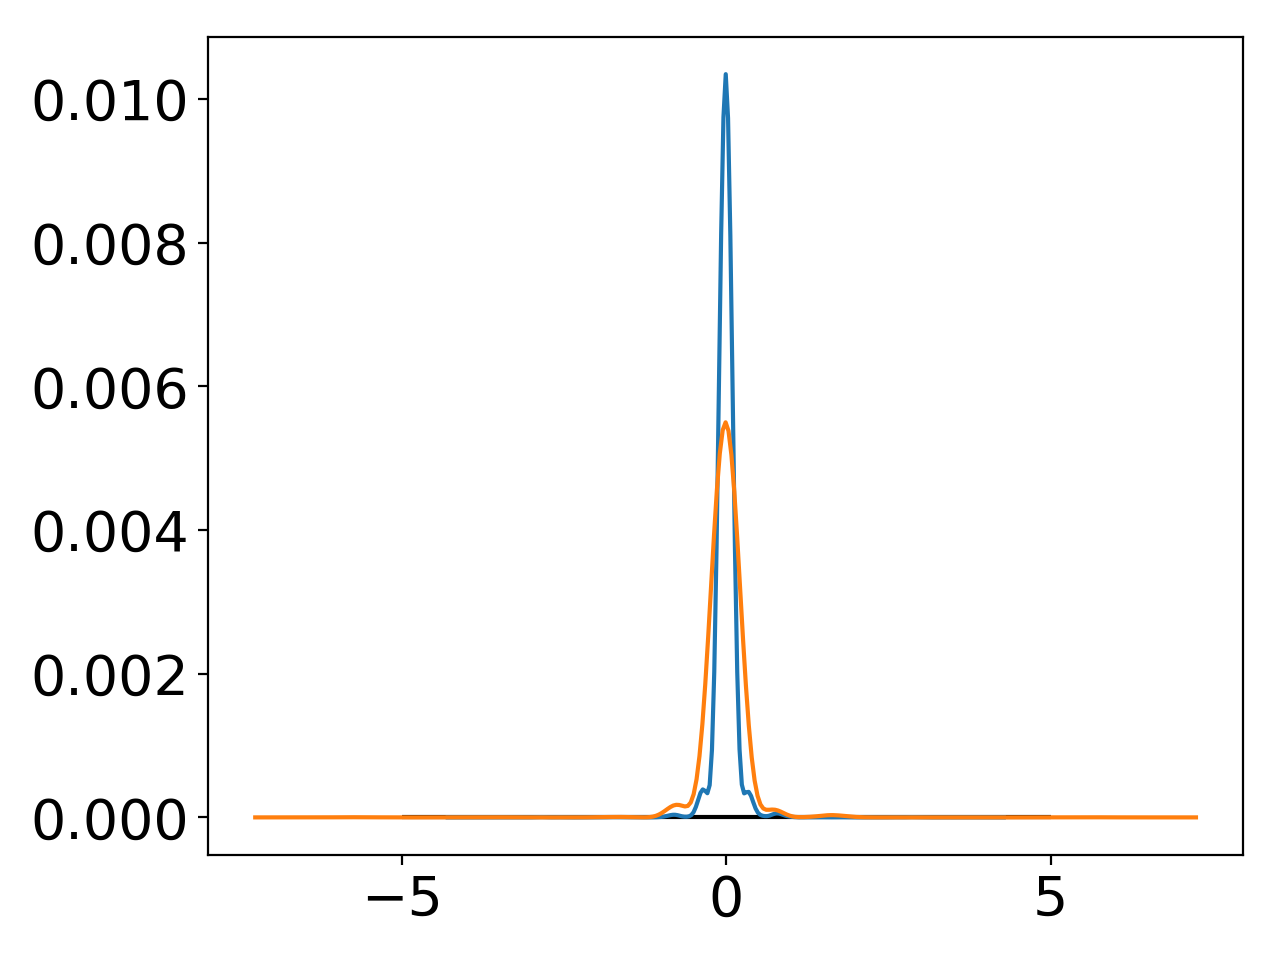

0.95753982987
0.951090098815


In [10]:
plt.figure()

psf_values = psffits_1B[1].data.transpose(2,1,0) # flip data from Z,Y,X to X,Y,Z
NAXIS1,NAXIS2,NAXIS3 = psf_values.shape
alphastpix   = psffits_1B[1].header['CRPIX1'] # pixel nr
alpha_step   = psffits_1B[1].header['CDELT1'] # arcsec/pix
stalpha      = psffits_1B[1].header['CRVAL1']-(alphastpix-1)*alpha_step # arcsec
alpha_slices = np.linspace(stalpha,stalpha+ (NAXIS1-1.5)*alpha_step,NAXIS1)

plt.plot(alpha_slices,psf_values[120,:,100])

print psf_values[:,:,100].sum()

psf_values = psffits_3A[1].data.transpose(2,1,0) # flip data from Z,Y,X to X,Y,Z
NAXIS1,NAXIS2,NAXIS3 = psf_values.shape
alphastpix   = psffits_3A[1].header['CRPIX1'] # pixel nr
alpha_step   = psffits_3A[1].header['CDELT1'] # arcsec/pix
stalpha      = psffits_3A[1].header['CRVAL1']-(alphastpix-1)*alpha_step # arcsec
alpha_slices = np.linspace(stalpha,stalpha+ (NAXIS1-1.5)*alpha_step,NAXIS1)

plt.plot(alpha_slices,psf_values[160,:,100])

plt.hlines(0,-5,5)
plt.tight_layout()

print psf_values[:,:,100].sum()


In [24]:
print np.mean(alpha_centers['1B'][~np.isnan(alpha_centers['1B'])])
print np.mean(beta_centers['1B'][~np.isnan(beta_centers['1B'])])

-0.191648309094
-0.0123721386646


In [20]:
psffits_1B = funcs.get_cdps('1B',cdpDir,output='img')[3]
# PSF CDP is provided as a spectral cube
#>get values
psf_values = psffits_1B[1].data.transpose(2,1,0) # flip data from Z,Y,X to X,Y,Z

#>get grid
NAXIS1,NAXIS2,NAXIS3 = psf_values.shape

alphastpix   = psffits_1B[1].header['CRPIX1'] # pixel nr
alpha_step   = psffits_1B[1].header['CDELT1'] # arcsec/pix
stalpha      = psffits_1B[1].header['CRVAL1']-(alphastpix-1)*alpha_step # arcsec

betastpix    = psffits_1B[1].header['CRPIX2'] # pixel nr
beta_step    = psffits_1B[1].header['CDELT2'] # arcsec/pix
stbeta       = psffits_1B[1].header['CRVAL2']-(betastpix-1)*beta_step # arcsec

stwavl       = psffits_1B[1].header['CRVAL3'] # microns
wavl_step    = psffits_1B[1].header['CDELT3'] # microns/pix

alpha_slices = np.linspace(stalpha,stalpha+ (NAXIS1-1.5)*alpha_step,NAXIS1)
beta_slices  = np.linspace(stbeta,stbeta+ (NAXIS2-1.5)*beta_step,NAXIS2)
wvl_slices   = np.linspace(stwavl ,stwavl+NAXIS3*wavl_step,NAXIS3)/2.

#> center psf to source
alpha_slices += np.mean(alpha_centers['1B'][~np.isnan(alpha_centers['1B'])])
beta_slices  += np.mean(beta_centers['1B'][~np.isnan(beta_centers['1B'])])

#> create interpolant based on regular grid
interpolpsf = scp_interpolate.RegularGridInterpolator((alpha_slices,beta_slices,wvl_slices),psf_values)
interpolpsf.fill_value=0.
interpolpsf.bounds_error=False

# evaluate psf at each pixel center and pixel corner
alphaULMap = d2cMaps_1B['alphaULMap']
alphaURMap = d2cMaps_1B['alphaURMap']
alphaLLMap = d2cMaps_1B['alphaLLMap']
alphaLRMap = d2cMaps_1B['alphaLRMap']
alphaMap   = d2cMaps_1B['alphaMap']

betaULMap = d2cMaps_1B['betaULMap']
betaURMap = d2cMaps_1B['betaURMap']
betaLLMap = d2cMaps_1B['betaLLMap']
betaLRMap = d2cMaps_1B['betaLRMap']
betaMap   = d2cMaps_1B['betaMap']

lambdaULMap_order2 = d2cMaps_1B['lambdaULMap']
lambdaURMap_order2 = d2cMaps_1B['lambdaURMap']
lambdaLLMap_order2 = d2cMaps_1B['lambdaLLMap']
lambdaLRMap_order2 = d2cMaps_1B['lambdaLRMap']
lambdaMap_order2 = d2cMaps_1B['lambdaMap']

#> interpolate psf to science image pixel centers and corners
#-- assume no significant change in wavelength over one pixel size
psfUL  = interpolpsf((alphaULMap,betaULMap,lambdaULMap_order2))
psfUR  = interpolpsf((alphaURMap,betaURMap,lambdaURMap_order2))
psfLL  = interpolpsf((alphaLLMap,betaLLMap,lambdaLLMap_order2))
psfLR  = interpolpsf((alphaLRMap,betaLRMap,lambdaLRMap_order2))
psfCEN = interpolpsf((alphaMap,betaMap,lambdaMap_order2))

#> evaluate psf as a weighted average
w = np.array([0.125,0.125,0.125,0.125,0.5]) # WARNING: ARBITRARY!
sumweights = w.sum()

psf_img_1B = (w[0]*psfUL+w[1]*psfUR+w[2]*psfLL+w[3]*psfLR+w[4]*psfCEN)/sumweights


In [38]:
psffits_3A = funcs.get_cdps('3A',cdpDir,output='img')[3]
# PSF CDP is provided as a spectral cube
#>get values
psf_values = psffits_3A[1].data.transpose(2,1,0) # flip data from Z,Y,X to X,Y,Z

#>get grid
NAXIS1,NAXIS2,NAXIS3 = psf_values.shape

alphastpix   = psffits[1].header['CRPIX1'] # pixel nr
alpha_step   = psffits[1].header['CDELT1'] # arcsec/pix
stalpha      = psffits[1].header['CRVAL1']-(alphastpix-1)*alpha_step # arcsec

betastpix    = psffits[1].header['CRPIX2'] # pixel nr
beta_step    = psffits[1].header['CDELT2'] # arcsec/pix
stbeta       = psffits[1].header['CRVAL2']-(betastpix-1)*beta_step # arcsec

stwavl       = psffits[1].header['CRVAL3'] # microns
wavl_step    = psffits[1].header['CDELT3'] # microns/pix

alpha_slices = np.linspace(stalpha,stalpha+ (NAXIS1-1.5)*alpha_step,NAXIS1)
beta_slices  = np.linspace(stbeta,stbeta+ (NAXIS2-1.5)*beta_step,NAXIS2)
wvl_slices   = np.linspace(stwavl ,stwavl+NAXIS3*wavl_step,NAXIS3)/2.

#> center psf to source
alpha_slices += np.mean(alpha_centers['1B'][~np.isnan(alpha_centers['1B'])])
beta_slices  += np.mean(beta_centers['1B'][~np.isnan(beta_centers['1B'])])

#> create interpolant based on regular grid
interpolpsf = scp_interpolate.RegularGridInterpolator((alpha_slices,beta_slices,wvl_slices),psf_values)
interpolpsf.fill_value=0.
interpolpsf.bounds_error=False

# evaluate psf at each pixel center and pixel corner
alphaULMap = d2cMaps_1B['alphaULMap']
alphaURMap = d2cMaps_1B['alphaURMap']
alphaLLMap = d2cMaps_1B['alphaLLMap']
alphaLRMap = d2cMaps_1B['alphaLRMap']
alphaMap   = d2cMaps_1B['alphaMap']

betaULMap = d2cMaps_1B['betaULMap']
betaURMap = d2cMaps_1B['betaURMap']
betaLLMap = d2cMaps_1B['betaLLMap']
betaLRMap = d2cMaps_1B['betaLRMap']
betaMap   = d2cMaps_1B['betaMap']

lambdaULMap_order2 = d2cMaps_1B['lambdaULMap']
lambdaURMap_order2 = d2cMaps_1B['lambdaURMap']
lambdaLLMap_order2 = d2cMaps_1B['lambdaLLMap']
lambdaLRMap_order2 = d2cMaps_1B['lambdaLRMap']
lambdaMap_order2 = d2cMaps_1B['lambdaMap']

#> interpolate psf to science image pixel centers and corners
#-- assume no significant change in wavelength over one pixel size
psfUL  = interpolpsf((alphaULMap,betaULMap,lambdaULMap_order2))
psfUR  = interpolpsf((alphaURMap,betaURMap,lambdaURMap_order2))
psfLL  = interpolpsf((alphaLLMap,betaLLMap,lambdaLLMap_order2))
psfLR  = interpolpsf((alphaLRMap,betaLRMap,lambdaLRMap_order2))
psfCEN = interpolpsf((alphaMap,betaMap,lambdaMap_order2))

#> evaluate psf as a weighted average
w = np.array([0.125,0.125,0.125,0.125,0.5]) # WARNING: ARBITRARY!
sumweights = w.sum()

psf_img_3A = (w[0]*psfUL+w[1]*psfUR+w[2]*psfLL+w[3]*psfLR+w[4]*psfCEN)/sumweights


In [23]:
for ibin in range(len(lambcens_1B)):
    # map containing only pixels within one spectral bin
    pixelsInBinNoNaN = np.where(np.abs(d2cMaps_1B['lambdaMap']-lambcens_1B[ibin])<lambfwhms_1B[ibin]/2.)
    # enforce normalization of psf in every wavelength bin
    psf_img_1B[pixelsInBinNoNaN] = psf_img_1B[pixelsInBinNoNaN]/psf_img_1B[pixelsInBinNoNaN].sum()
    
for ibin in range(len(lambcens_3A)):
    # map containing only pixels within one spectral bin
    pixelsInBinNoNaN = np.where(np.abs(d2cMaps_3A['lambdaMap']-lambcens_3A[ibin])<lambfwhms_3A[ibin]/2.)
    # enforce normalization of psf in every wavelength bin
    psf_img_3A[pixelsInBinNoNaN] = psf_img_3A[pixelsInBinNoNaN]/psf_img_3A[pixelsInBinNoNaN].sum()

/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide


In [ ]:
from scipy import signal
test_img = signal.convolve2d(psf_img_1B,psf_img_3A,mode='same')

plt.figure(figsize=(12,5))
plt.plot(psf_img_1B[512,:512])
plt.plot(1+np.arange(512),psf_img_3A[512,:512])
# plt.plot(point_source_bkgsubtr_1B[512,:512])
plt.plot(test_img[512,:512])
plt.hlines(0,0,512)
plt.tight_layout()

<IPython.core.display.Javascript object>


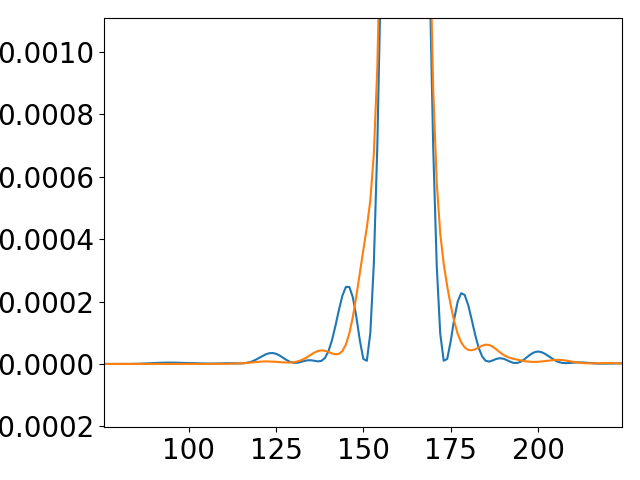

In [50]:
plt.figure()
plt.plot(np.arange(len(psffits_3A[1].data[200,:,:][161,:])),psffits_3A[1].data[200,:,:][161,:])
plt.plot(41+np.arange(len(psffits_1B[1].data[200,:,:][119,:])),psffits_1B[1].data[200,:,:][119,:])
plt.tight_layout()

<IPython.core.display.Javascript object>


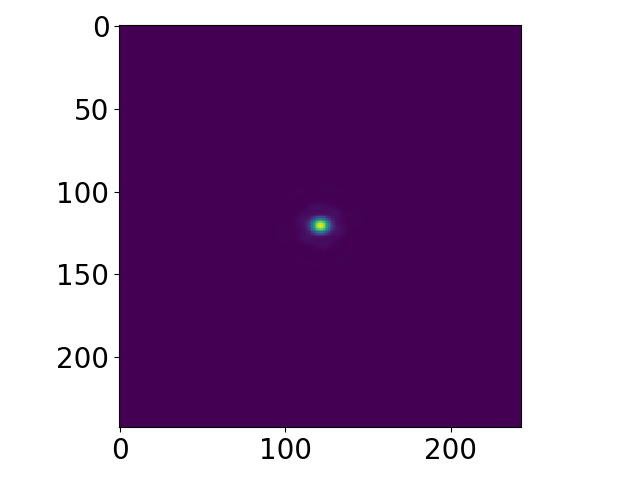

<IPython.core.display.Javascript object>


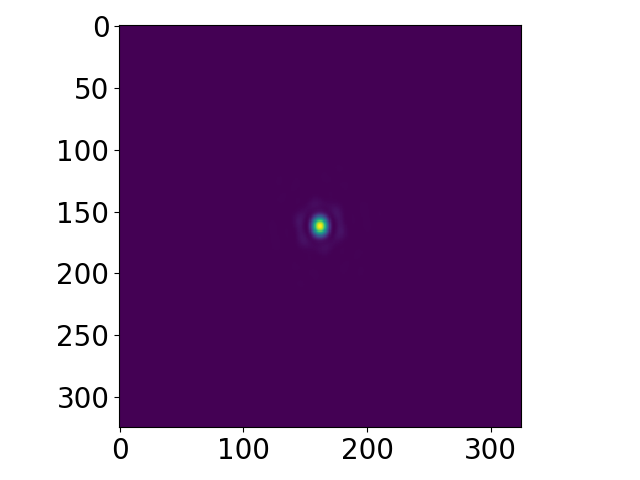

In [51]:
plt.figure()
plt.imshow(psffits_1B[1].data[200,:,:])
plt.tight_layout()
plt.figure()
plt.imshow(psffits_3A[1].data[200,:,:])
plt.tight_layout()